In [1]:
import os
import glob
import numpy as np
import pandas as pd
import skimage.morphology


In [2]:
params_file = './params.xlsx'

In [3]:
def computeBoundaries(signal, th):
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]

    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((1300, 1)) #70,1
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]

    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)

    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]

    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

In [4]:
def compute_segment_lengths(starting, ending):
    return ending - starting

def compute_statistics(lengths):
    average = np.mean(lengths)
    std_dev = np.std(lengths)
    return average, std_dev

def compute_large_gaps(starting, ending, gap_threshold=1300):
    gaps = starting[1:] - ending[:-1]
    print(gaps)
    large_gaps = np.sum(gaps > gap_threshold)
    return large_gaps


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_boundaries(raw_data_list, processed_data, file_number):
    channel_names = ["Trigger (Machine)", "Flat Response Microphone (Front)", 
                     "Flat Response Microphone (Rear)", "Resonant Microphone"]
    
    sampling_freq = 200000  # Sampling frequency in Hz
    fig, axs = plt.subplots(len(raw_data_list), 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f'Signal {file_number}', fontsize=16)
    plt.subplots_adjust(hspace=0.5)

    for j, signal_data in enumerate(raw_data_list):
        channel_index = j + 1  # Adjusting for 0-based index
        starting, ending = processed_data.get(f'Channel_{channel_index}', {}).get('boundaries', ([], []))
        
        # Convert sample indices to time
        time_axis = np.arange(len(signal_data)) / sampling_freq
        
        # Plot using time_axis for the x-axis
        axs[j].plot(time_axis, signal_data, label=f'Channel {channel_index} - {channel_names[channel_index]}')
        
        # Convert starting and ending indices to time
        starting_time = starting / sampling_freq
        ending_time = ending / sampling_freq
        
        # Scatter plot for starting and ending points using converted time
        axs[j].scatter(starting_time, signal_data[starting], color='g', label='Starting', zorder=5)
        axs[j].scatter(ending_time, signal_data[ending], color='r', label='Ending', zorder=5)
        
        axs[j].legend(loc="upper right")
        axs[j].set_title(channel_names[channel_index]+ " " +processed_data.get(f'Channel_{channel_index}', {}).get('Operation', ([])))
        axs[j].set_ylabel('Amplitude (V)')
        axs[j].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()


In [6]:
import os
import pandas as pd
import warnings


def process_file(channels, file_name, threshold, excel_path):
    th = 10000
    # Read the corresponding row from the Excel file based on file_number
    excel_data = pd.read_excel(excel_path)
    
    # Use regular expression to find all numbers in the string
    numbers_in_string = re.findall(r'\d+', file_name)

    # Convert the first found number to integer
    file_number = int(numbers_in_string[0]) if numbers_in_string else None
    row = excel_data.iloc[file_number]
    operation = row['Operation']
    cube_1_mode = row['Cube 1 Mode']
    cube_2_mode = row['Cube 2 Mode']

    file_data = {}
    raw_data_list = []  # To store raw data for each channel
    print(f"\nProcessing File: {file_name}, Operation: {operation}, Cube 1 Mode: {cube_1_mode}, Cube 2 Mode: {cube_2_mode}")

    for channel_index, channel_path in enumerate(channels):
        if channel_index == 0:  # Skip Channel 0
            print("Skipping Channel 0 as per requirements.")
            continue
        
        channel_file_path = os.path.join(channel_path, f"{file_name}.parquet")
        print(f"Reading data from {channel_file_path} for Channel {channel_index}")
        channel_data = pd.read_parquet(channel_file_path)
        signal_data = channel_data.iloc[:, 0].values  # The signal data is in the first column
        raw_data_list.append(signal_data)  # Store raw data

        # Compute boundaries and segments
        if channel_index == 3:  # Use Channel 2's boundaries for Channel 3
            starting, ending = file_data['Channel_2']['boundaries']
            print("Using vecchia ciabatta")
        else:
            starting, ending = computeBoundaries(signal_data, threshold)
        
        segments = [signal_data[start:end+1] for start, end in zip(starting, ending) if end-start+1 >= th]
        starting_pruned = np.array([start for start, end in zip(starting, ending) if end-start+1 >= th])
        ending_pruned = np.array([end for start, end in zip(starting, ending) if end-start+1 >= th])
        
#         if len(segments) < len(starting):  # If any segments are excluded
#             warnings.warn(f"Warning: Excluded segment smaller than {th} points.")
        
        segment_lengths = [len(segment) for segment in segments]
        avg_length, std_dev = compute_statistics(segment_lengths)
        num_segments = len(segments)

        # Add extracted information and processed data to file_data
        file_data[f'Channel_{channel_index}'] = {
            'Operation': operation,
            'Cube 1 Mode': cube_1_mode,
            'Cube 2 Mode': cube_2_mode,
            'segments': segments,
            'boundaries': (starting_pruned, ending_pruned),
            'avg_length': avg_length,
            'std_dev': std_dev,
            'num_segments': num_segments
        }

        print(f"Channel {channel_index}: Processed with {len(segments)} segments detected.")
        print(f"Average Segment Length: {avg_length:.2f}, Standard Deviation: {std_dev:.2f}, Num. segments: {num_segments}")
        
        # Large gaps validation after excluding small segments
        if (operation == "Sequential" and num_segments != 2) or (operation == "Simultaneous" and num_segments != 1):
            warnings.warn(f"Warning: Expected segment count not met for {operation} operation. Num. segments: {num_segments}")

    return file_data, raw_data_list


In [7]:
import random
import glob
import os
import re

from tqdm import tqdm


def parse_multimodal_signals_corrected_with_plotting(path, threshold=1.0, N=10):
    channels = glob.glob(os.path.join(path, "*/"))
    channels.sort()
    
    sample_files = glob.glob(os.path.join(channels[0], "*.parquet"))
    sample_files.sort(key=lambda x: int(re.search(r'File_(\d+)', x).group(1)))
        
    all_processed_data = {}
    problematic_files = []  # List to store file numbers of problematic files

    for sample_file in tqdm(sample_files, desc="Processing files"):
        
        file_name = os.path.splitext(os.path.basename(sample_file))[0]
        try:
            processed_data, raw_data_list = process_file(channels, file_name, threshold, params_file)

            # Initialize a flag to track if the file is problematic
            is_problematic = False

            # Iterate through processed data to check large gaps for each channel
            for channel_key, channel_info in processed_data.items():
                if channel_key == 'Channel_0':
                    continue  # Skip Channel 0 as per original requirement

                # Extract operation type for the current file from the processed_data
                operation_type = channel_info['Operation']

                # Determine the expected number of large gaps
                expected_segments = 2 if operation_type == 'Sequential' else 1

                if channel_info['num_segments'] != expected_segments:
                    print(f"Warning: File_{file_name} in {channel_key} has {channel_info['num_segments']} segments instead of {expected_segments}.")
                    problematic_files.append(file_name)
                    is_problematic = True
                    break  # Assuming if one channel is problematic, the file is considered problematic

            if not is_problematic:
                all_processed_data[file_name] = processed_data
                
        except IndexError as e:
            print(f"Error processing File_{file_number}: {e}")
            problematic_files.append(file_number)  # Add to problematic files if an IndexError occurs
        
        if (len(all_processed_data) + len(problematic_files)) % 10 == 0:  # Plot after processing every 10 files
            print(f"Plotting signals processed up to file number: {file_name}")
            plot_signals_with_boundaries(raw_data_list, processed_data, file_name)
            print('----'*32)
        
    if problematic_files:
        print(f"Problematic files (large gaps not as expected): {problematic_files}")
    
    return all_processed_data


Processing files:   0%|                                 | 0/400 [00:00<?, ?it/s]


Processing File: File_0, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_0.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428282.00, Standard Deviation: 126.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_0.parquet for Channel 2


Processing files:   0%|                       | 1/400 [00:15<1:43:18, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426719.00, Standard Deviation: 524.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_0.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426719.00, Standard Deviation: 524.00, Num. segments: 2

Processing File: File_1, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_1.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427154.50, Standard Deviation: 173.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_1.parquet for Channel 2


Processing files:   0%|                       | 2/400 [00:30<1:42:34, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426428.50, Standard Deviation: 217.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_1.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426428.50, Standard Deviation: 217.50, Num. segments: 2

Processing File: File_2, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_2.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428337.50, Standard Deviation: 1164.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_2.parquet for Channel 2


Processing files:   1%|▏                      | 3/400 [00:46<1:42:10, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 427554.00, Standard Deviation: 150.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_2.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 427554.00, Standard Deviation: 150.00, Num. segments: 2

Processing File: File_3, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_3.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427645.50, Standard Deviation: 297.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_3.parquet for Channel 2


Processing files:   1%|▏                      | 4/400 [01:01<1:41:50, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425758.00, Standard Deviation: 1.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_3.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425758.00, Standard Deviation: 1.00, Num. segments: 2

Processing File: File_4, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_4.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428812.00, Standard Deviation: 6.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_4.parquet for Channel 2


Processing files:   1%|▎                      | 5/400 [01:17<1:41:39, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 427467.50, Standard Deviation: 346.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_4.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 427467.50, Standard Deviation: 346.50, Num. segments: 2

Processing File: File_5, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_5.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427351.50, Standard Deviation: 616.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_5.parquet for Channel 2


Processing files:   2%|▎                      | 6/400 [01:32<1:41:37, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426471.50, Standard Deviation: 562.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_5.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426471.50, Standard Deviation: 562.50, Num. segments: 2

Processing File: File_6, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_6.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428734.00, Standard Deviation: 493.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_6.parquet for Channel 2


Processing files:   2%|▍                      | 7/400 [01:48<1:41:24, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 427080.00, Standard Deviation: 223.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_6.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 427080.00, Standard Deviation: 223.00, Num. segments: 2

Processing File: File_7, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_7.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427174.00, Standard Deviation: 1219.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_7.parquet for Channel 2


Processing files:   2%|▍                      | 8/400 [02:03<1:41:14, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425955.00, Standard Deviation: 686.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_7.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425955.00, Standard Deviation: 686.00, Num. segments: 2

Processing File: File_8, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_8.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427736.00, Standard Deviation: 233.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_8.parquet for Channel 2


Processing files:   2%|▌                      | 9/400 [02:19<1:40:46, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426311.00, Standard Deviation: 680.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_8.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426311.00, Standard Deviation: 680.00, Num. segments: 2

Processing File: File_9, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_9.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426996.50, Standard Deviation: 1062.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_9.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 424977.00, Standard Deviation: 338.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_9.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 seg

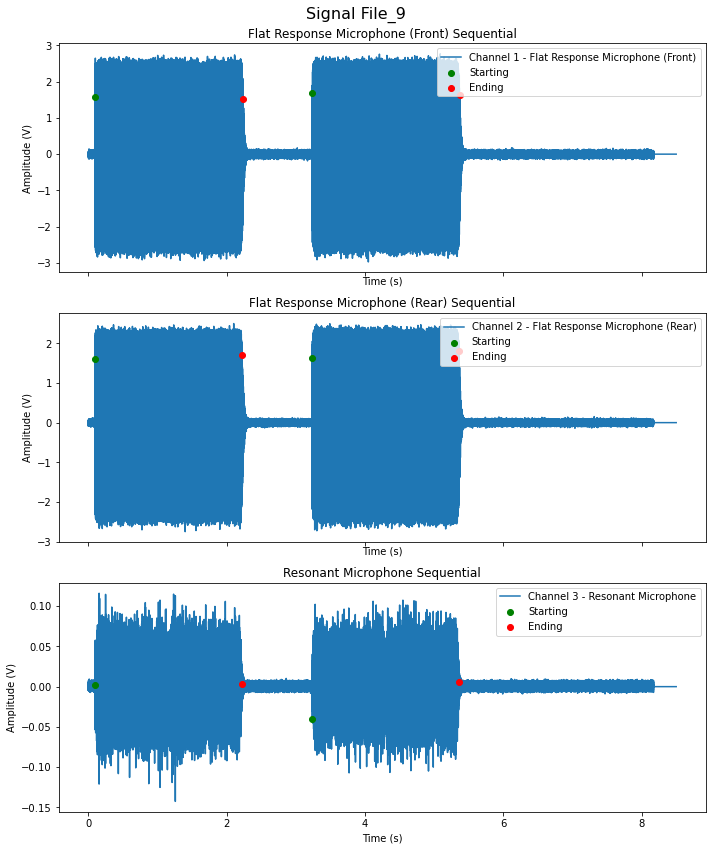

Processing files:   2%|▌                     | 10/400 [02:35<1:42:29, 15.77s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_10, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_10.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430816.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_10.parquet for Channel 2


Processing files:   3%|▌                     | 11/400 [02:51<1:41:25, 15.64s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427633.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_10.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427633.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_11, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_11.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428501.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_11.parquet for Channel 2


Processing files:   3%|▋                     | 12/400 [03:06<1:40:39, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428210.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_11.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428210.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_12, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_12.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430752.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_12.parquet for Channel 2


Processing files:   3%|▋                     | 13/400 [03:21<1:40:02, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429531.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_12.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429531.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_13, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_13.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429258.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_13.parquet for Channel 2


Processing files:   4%|▊                     | 14/400 [03:37<1:39:33, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427829.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_13.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427829.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_14, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_14.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430312.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_14.parquet for Channel 2


Processing files:   4%|▊                     | 15/400 [03:52<1:39:08, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429512.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_14.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429512.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_15, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_15.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429317.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_15.parquet for Channel 2


Processing files:   4%|▉                     | 16/400 [04:07<1:38:44, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427330.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_15.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427330.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_16, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_16.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430693.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_16.parquet for Channel 2


Processing files:   4%|▉                     | 17/400 [04:23<1:38:24, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429260.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_16.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429260.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_17, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_17.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429460.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_17.parquet for Channel 2


Processing files:   4%|▉                     | 18/400 [04:38<1:38:04, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 426873.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_17.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 426873.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_18, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_18.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 432012.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_18.parquet for Channel 2


Processing files:   5%|█                     | 19/400 [04:54<1:37:46, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429472.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_18.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429472.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_19, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_19.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429548.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_19.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 427351.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_19.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

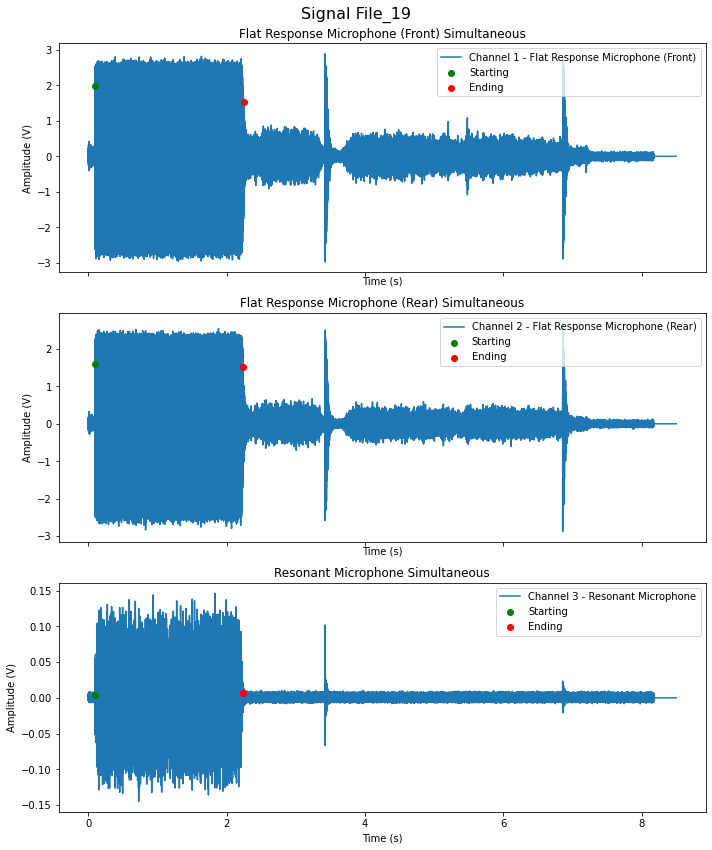

Processing files:   5%|█                     | 20/400 [05:10<1:39:11, 15.66s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_20, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_20.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427336.50, Standard Deviation: 944.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_20.parquet for Channel 2


Processing files:   5%|█▏                    | 21/400 [05:25<1:38:24, 15.58s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426147.50, Standard Deviation: 30.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_20.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426147.50, Standard Deviation: 30.50, Num. segments: 2

Processing File: File_21, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_21.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426410.00, Standard Deviation: 457.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_21.parquet for Channel 2


Processing files:   6%|█▏                    | 22/400 [05:41<1:38:11, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425257.50, Standard Deviation: 240.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_21.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425257.50, Standard Deviation: 240.50, Num. segments: 2

Processing File: File_22, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_22.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427345.50, Standard Deviation: 398.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_22.parquet for Channel 2


Processing files:   6%|█▎                    | 23/400 [05:56<1:37:37, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426413.00, Standard Deviation: 172.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_22.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426413.00, Standard Deviation: 172.00, Num. segments: 2

Processing File: File_23, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_23.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427289.50, Standard Deviation: 431.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_23.parquet for Channel 2


Processing files:   6%|█▎                    | 24/400 [06:12<1:37:06, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425286.00, Standard Deviation: 1238.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_23.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425286.00, Standard Deviation: 1238.00, Num. segments: 2

Processing File: File_24, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_24.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427747.00, Standard Deviation: 556.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_24.parquet for Channel 2


Processing files:   6%|█▍                    | 25/400 [06:27<1:36:40, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426139.50, Standard Deviation: 587.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_24.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426139.50, Standard Deviation: 587.50, Num. segments: 2

Processing File: File_25, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_25.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 425964.00, Standard Deviation: 483.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_25.parquet for Channel 2


Processing files:   6%|█▍                    | 26/400 [06:43<1:36:40, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424874.50, Standard Deviation: 767.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_25.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424874.50, Standard Deviation: 767.50, Num. segments: 2

Processing File: File_26, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_26.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 428920.50, Standard Deviation: 1502.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_26.parquet for Channel 2


Processing files:   7%|█▍                    | 27/400 [06:58<1:36:27, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426161.50, Standard Deviation: 1317.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_26.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426161.50, Standard Deviation: 1317.50, Num. segments: 2

Processing File: File_27, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_27.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426635.00, Standard Deviation: 846.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_27.parquet for Channel 2


Processing files:   7%|█▌                    | 28/400 [07:14<1:35:59, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425297.00, Standard Deviation: 603.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_27.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425297.00, Standard Deviation: 603.00, Num. segments: 2

Processing File: File_28, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_28.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427091.50, Standard Deviation: 655.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_28.parquet for Channel 2


Processing files:   7%|█▌                    | 29/400 [07:29<1:35:27, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425386.00, Standard Deviation: 704.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_28.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425386.00, Standard Deviation: 704.00, Num. segments: 2

Processing File: File_29, Operation: Sequential, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_29.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426522.00, Standard Deviation: 1003.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_29.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 424993.00, Standard Deviation: 771.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_29.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 

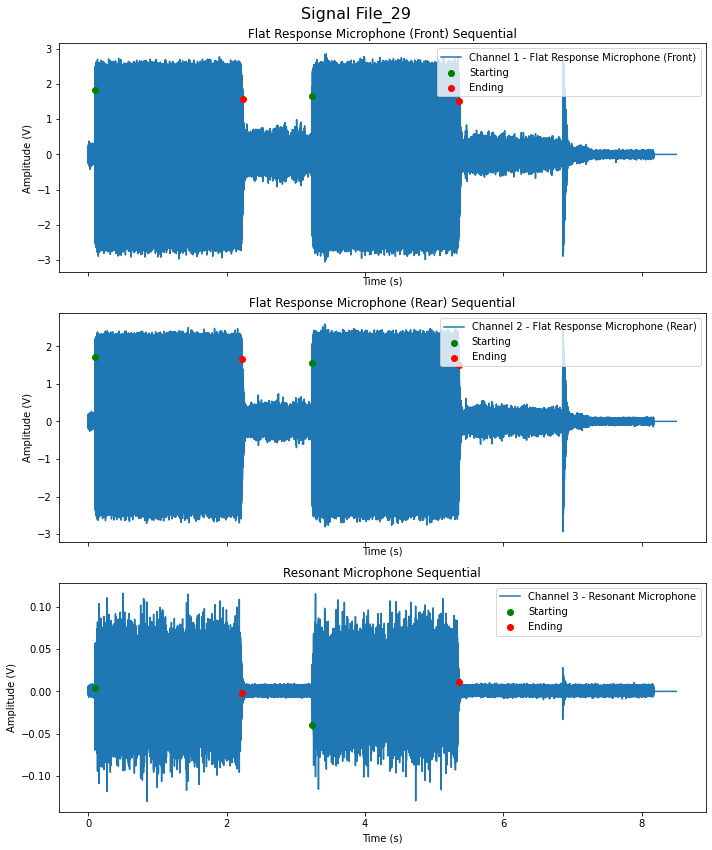

Processing files:   8%|█▋                    | 30/400 [07:45<1:36:50, 15.70s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_30, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_30.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429287.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_30.parquet for Channel 2


Processing files:   8%|█▋                    | 31/400 [08:01<1:35:53, 15.59s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428041.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_30.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428041.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_31, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_31.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429684.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_31.parquet for Channel 2


Processing files:   8%|█▊                    | 32/400 [08:16<1:35:10, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427534.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_31.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427534.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_32, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_32.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430303.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_32.parquet for Channel 2


Processing files:   8%|█▊                    | 33/400 [08:31<1:34:37, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428064.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_32.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428064.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_33, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_33.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428755.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_33.parquet for Channel 2


Processing files:   8%|█▊                    | 34/400 [08:47<1:34:10, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427664.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_33.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427664.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_34, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_34.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430564.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_34.parquet for Channel 2


Processing files:   9%|█▉                    | 35/400 [09:02<1:33:47, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428792.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_34.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428792.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_35, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_35.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428227.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_35.parquet for Channel 2


Processing files:   9%|█▉                    | 36/400 [09:17<1:33:27, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427251.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_35.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427251.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_36, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_36.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430537.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_36.parquet for Channel 2


Processing files:   9%|██                    | 37/400 [09:33<1:33:07, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428077.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_36.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428077.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_37, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_37.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429004.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_37.parquet for Channel 2


Processing files:  10%|██                    | 38/400 [09:48<1:32:50, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428571.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_37.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428571.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_38, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_38.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430822.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_38.parquet for Channel 2


Processing files:  10%|██▏                   | 39/400 [10:04<1:32:33, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428797.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_38.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428797.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_39, Operation: Simultaneous, Cube 1 Mode: Conduction 2, Cube 2 Mode: Conduction 2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_39.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429052.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_39.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 427284.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_39.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

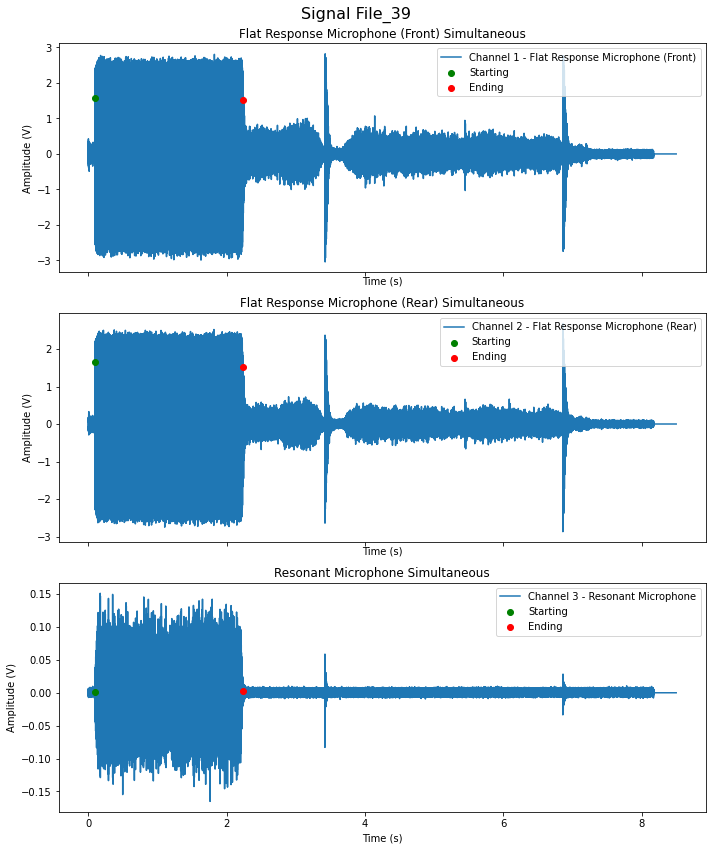

Processing files:  10%|██▏                   | 40/400 [10:20<1:33:51, 15.64s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_40, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_40.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 485285.00, Standard Deviation: 1001.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_40.parquet for Channel 2


Processing files:  10%|██▎                   | 41/400 [10:35<1:33:06, 15.56s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483206.00, Standard Deviation: 771.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_40.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483206.00, Standard Deviation: 771.00, Num. segments: 2

Processing File: File_41, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_41.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 483675.50, Standard Deviation: 1148.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_41.parquet for Channel 2


Processing files:  10%|██▎                   | 42/400 [10:51<1:32:31, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 482589.50, Standard Deviation: 174.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_41.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 482589.50, Standard Deviation: 174.50, Num. segments: 2

Processing File: File_42, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_42.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 485348.00, Standard Deviation: 156.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_42.parquet for Channel 2


Processing files:  11%|██▎                   | 43/400 [11:06<1:32:02, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483966.00, Standard Deviation: 219.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_42.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483966.00, Standard Deviation: 219.00, Num. segments: 2

Processing File: File_43, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_43.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484199.50, Standard Deviation: 1948.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_43.parquet for Channel 2


Processing files:  11%|██▍                   | 44/400 [11:21<1:31:37, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 482592.00, Standard Deviation: 957.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_43.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 482592.00, Standard Deviation: 957.00, Num. segments: 2

Processing File: File_44, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_44.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484922.50, Standard Deviation: 163.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_44.parquet for Channel 2


Processing files:  11%|██▍                   | 45/400 [11:37<1:31:13, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 484169.00, Standard Deviation: 537.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_44.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 484169.00, Standard Deviation: 537.00, Num. segments: 2

Processing File: File_45, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_45.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484064.00, Standard Deviation: 865.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_45.parquet for Channel 2


Processing files:  12%|██▌                   | 46/400 [11:52<1:30:53, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 482356.50, Standard Deviation: 1047.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_45.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 482356.50, Standard Deviation: 1047.50, Num. segments: 2

Processing File: File_46, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_46.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 485022.00, Standard Deviation: 373.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_46.parquet for Channel 2


Processing files:  12%|██▌                   | 47/400 [12:07<1:30:34, 15.39s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483923.00, Standard Deviation: 712.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_46.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483923.00, Standard Deviation: 712.00, Num. segments: 2

Processing File: File_47, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_47.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484062.50, Standard Deviation: 1166.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_47.parquet for Channel 2


Processing files:  12%|██▋                   | 48/400 [12:23<1:30:32, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 482437.50, Standard Deviation: 215.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_47.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 482437.50, Standard Deviation: 215.50, Num. segments: 2

Processing File: File_48, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_48.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484624.50, Standard Deviation: 611.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_48.parquet for Channel 2


Processing files:  12%|██▋                   | 49/400 [12:38<1:30:28, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483500.50, Standard Deviation: 538.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_48.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483500.50, Standard Deviation: 538.50, Num. segments: 2

Processing File: File_49, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_49.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484534.50, Standard Deviation: 1075.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_49.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 483125.00, Standard Deviation: 0.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_49.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 se

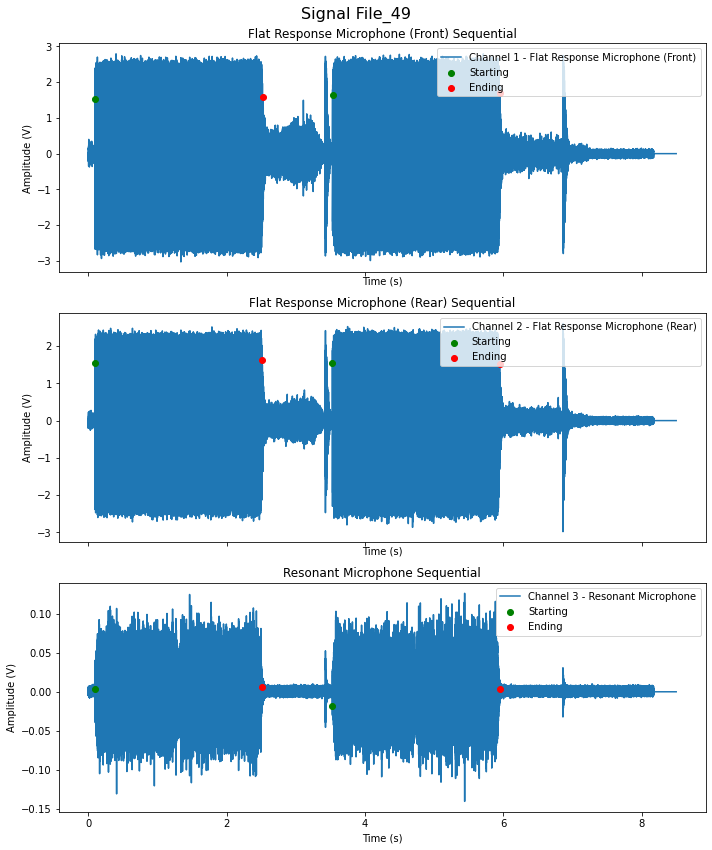

Processing files:  12%|██▊                   | 50/400 [12:55<1:31:54, 15.76s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_50, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_50.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 485301.00, Standard Deviation: 283.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_50.parquet for Channel 2


Processing files:  13%|██▊                   | 51/400 [13:10<1:30:56, 15.64s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483517.00, Standard Deviation: 663.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_50.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483517.00, Standard Deviation: 663.00, Num. segments: 2

Processing File: File_51, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_51.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484106.00, Standard Deviation: 952.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_51.parquet for Channel 2


Processing files:  13%|██▊                   | 52/400 [13:26<1:30:12, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 482721.50, Standard Deviation: 555.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_51.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 482721.50, Standard Deviation: 555.50, Num. segments: 2

Processing File: File_52, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_52.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 485552.00, Standard Deviation: 621.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_52.parquet for Channel 2


Processing files:  13%|██▉                   | 53/400 [13:41<1:29:34, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483841.00, Standard Deviation: 490.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_52.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483841.00, Standard Deviation: 490.00, Num. segments: 2

Processing File: File_53, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_53.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 484956.50, Standard Deviation: 1080.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_53.parquet for Channel 2


Processing files:  14%|██▉                   | 54/400 [13:56<1:29:05, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483309.00, Standard Deviation: 982.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_53.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483309.00, Standard Deviation: 982.00, Num. segments: 2

Processing File: File_54, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_54.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 485059.50, Standard Deviation: 977.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_54.parquet for Channel 2


Processing files:  14%|███                   | 55/400 [14:12<1:28:39, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 483521.00, Standard Deviation: 978.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_54.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 483521.00, Standard Deviation: 978.00, Num. segments: 2

Processing File: File_55, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_55.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 486464.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_55.parquet for Channel 2


Processing files:  14%|███                   | 56/400 [14:27<1:28:18, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 485130.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_55.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 485130.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_56, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_56.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 488946.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_56.parquet for Channel 2


Processing files:  14%|███▏                  | 57/400 [14:42<1:27:59, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 487552.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_56.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 487552.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_57, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_57.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 486865.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_57.parquet for Channel 2


Processing files:  14%|███▏                  | 58/400 [14:58<1:27:41, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 484840.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_57.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 484840.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_58, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_58.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 490297.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_58.parquet for Channel 2


Processing files:  15%|███▏                  | 59/400 [15:13<1:27:24, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 487059.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_58.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 487059.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_59, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_59.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 486418.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_59.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 485408.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_59.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segment

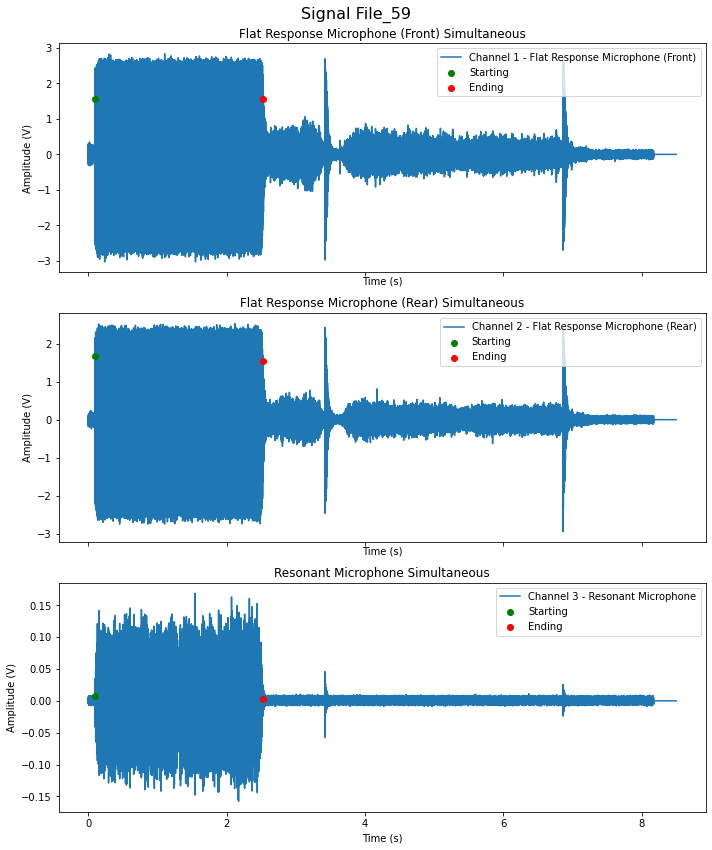

Processing files:  15%|███▎                  | 60/400 [15:29<1:28:38, 15.64s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_60, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_60.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 487830.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_60.parquet for Channel 2


Processing files:  15%|███▎                  | 61/400 [15:45<1:27:54, 15.56s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 485942.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_60.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 485942.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_61, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_61.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 486738.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_61.parquet for Channel 2


Processing files:  16%|███▍                  | 62/400 [16:00<1:27:18, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 485269.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_61.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 485269.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_62, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_62.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 488299.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_62.parquet for Channel 2


Processing files:  16%|███▍                  | 63/400 [16:15<1:26:49, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 486129.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_62.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 486129.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_63, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_63.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 487571.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_63.parquet for Channel 2


Processing files:  16%|███▌                  | 64/400 [16:31<1:26:25, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 485117.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_63.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 485117.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_64, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_64.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 489137.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_64.parquet for Channel 2


Processing files:  16%|███▌                  | 65/400 [16:46<1:26:03, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 486211.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_64.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 486211.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_65, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_65.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 486830.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_65.parquet for Channel 2


Processing files:  16%|███▋                  | 66/400 [17:02<1:25:43, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 484741.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_65.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 484741.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_66, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_66.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 487739.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_66.parquet for Channel 2


Processing files:  17%|███▋                  | 67/400 [17:17<1:25:24, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 486957.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_66.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 486957.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_67, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_67.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 487356.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_67.parquet for Channel 2


Processing files:  17%|███▋                  | 68/400 [17:32<1:25:10, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 485089.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_67.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 485089.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_68, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_68.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 487229.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_68.parquet for Channel 2


Processing files:  17%|███▊                  | 69/400 [17:48<1:24:48, 15.37s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 486367.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_68.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 486367.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_69, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_69.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 486260.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_69.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 484792.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_69.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segment

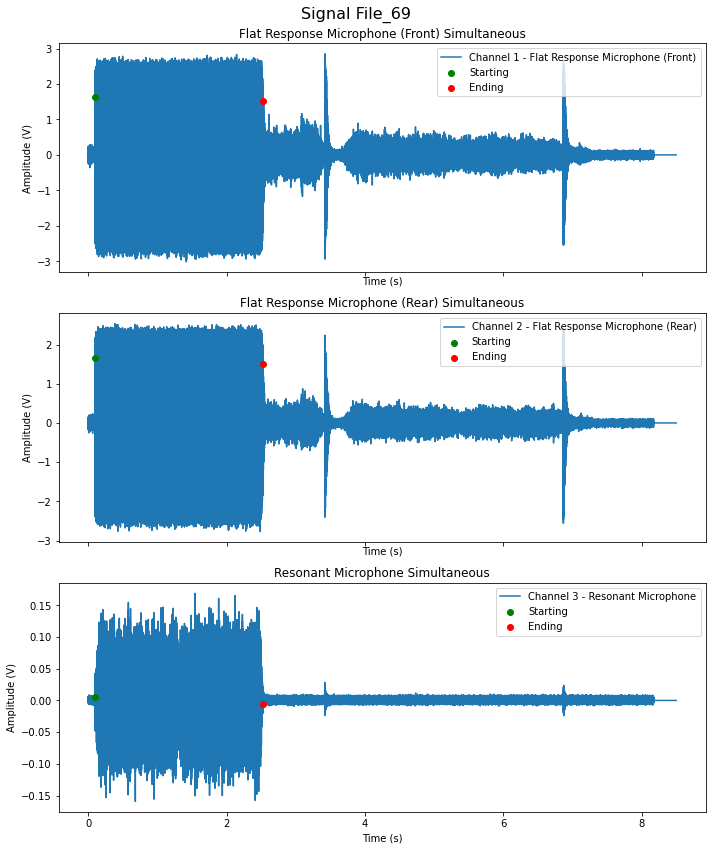

Processing files:  18%|███▊                  | 70/400 [18:04<1:25:55, 15.62s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_70, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_70.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427731.00, Standard Deviation: 512.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_70.parquet for Channel 2


Processing files:  18%|███▉                  | 71/400 [18:19<1:25:12, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425643.00, Standard Deviation: 660.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_70.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425643.00, Standard Deviation: 660.00, Num. segments: 2

Processing File: File_71, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_71.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426630.50, Standard Deviation: 893.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_71.parquet for Channel 2


Processing files:  18%|███▉                  | 72/400 [18:35<1:24:38, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424656.50, Standard Deviation: 818.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_71.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424656.50, Standard Deviation: 818.50, Num. segments: 2

Processing File: File_72, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_72.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427384.50, Standard Deviation: 386.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_72.parquet for Channel 2


Processing files:  18%|████                  | 73/400 [18:50<1:24:09, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426445.50, Standard Deviation: 657.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_72.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426445.50, Standard Deviation: 657.50, Num. segments: 2

Processing File: File_73, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_73.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 425735.00, Standard Deviation: 445.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_73.parquet for Channel 2


Processing files:  18%|████                  | 74/400 [19:05<1:23:49, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424603.00, Standard Deviation: 402.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_73.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424603.00, Standard Deviation: 402.00, Num. segments: 2

Processing File: File_74, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_74.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427652.50, Standard Deviation: 548.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_74.parquet for Channel 2


Processing files:  19%|████▏                 | 75/400 [19:21<1:23:29, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 426042.50, Standard Deviation: 988.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_74.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 426042.50, Standard Deviation: 988.50, Num. segments: 2

Processing File: File_75, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_75.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426387.50, Standard Deviation: 1231.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_75.parquet for Channel 2


Processing files:  19%|████▏                 | 76/400 [19:36<1:23:09, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424902.00, Standard Deviation: 405.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_75.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424902.00, Standard Deviation: 405.00, Num. segments: 2

Processing File: File_76, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_76.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426916.50, Standard Deviation: 511.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_76.parquet for Channel 2


Processing files:  19%|████▏                 | 77/400 [19:51<1:22:53, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425775.00, Standard Deviation: 659.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_76.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425775.00, Standard Deviation: 659.00, Num. segments: 2

Processing File: File_77, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_77.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426344.50, Standard Deviation: 633.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_77.parquet for Channel 2


Processing files:  20%|████▎                 | 78/400 [20:07<1:22:50, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424734.50, Standard Deviation: 57.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_77.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424734.50, Standard Deviation: 57.50, Num. segments: 2

Processing File: File_78, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_78.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427400.50, Standard Deviation: 654.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_78.parquet for Channel 2


Processing files:  20%|████▎                 | 79/400 [20:22<1:22:42, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425445.00, Standard Deviation: 646.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_78.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425445.00, Standard Deviation: 646.00, Num. segments: 2

Processing File: File_79, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_79.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427193.50, Standard Deviation: 1185.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_79.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 424809.50, Standard Deviation: 572.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_79.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 

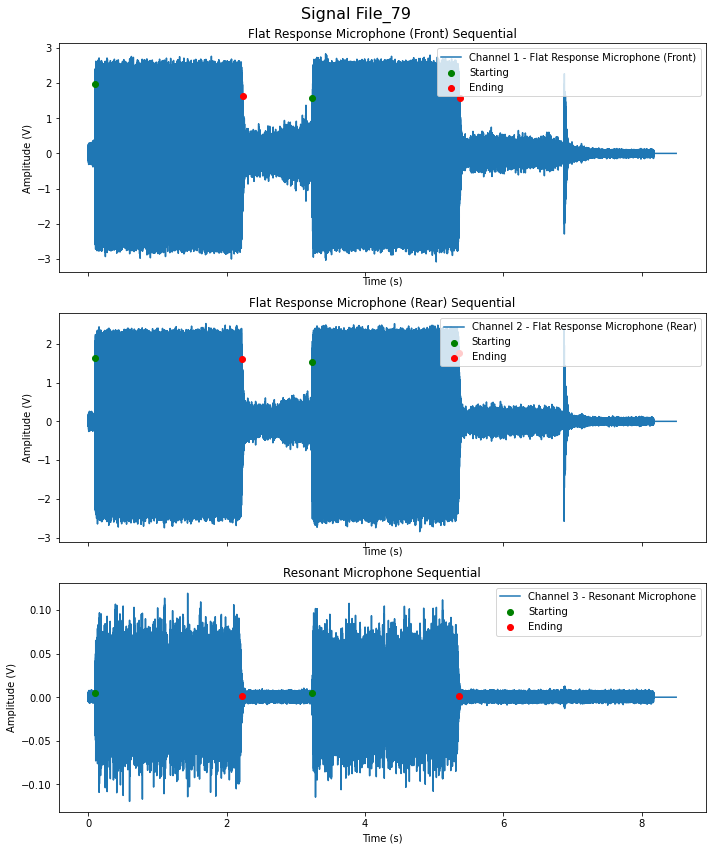

Processing files:  20%|████▍                 | 80/400 [20:39<1:24:16, 15.80s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_80, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_80.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427331.00, Standard Deviation: 1261.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_80.parquet for Channel 2


Processing files:  20%|████▍                 | 81/400 [20:55<1:23:28, 15.70s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425889.50, Standard Deviation: 548.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_80.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425889.50, Standard Deviation: 548.50, Num. segments: 2

Processing File: File_81, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_81.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426637.00, Standard Deviation: 558.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_81.parquet for Channel 2


Processing files:  20%|████▌                 | 82/400 [21:10<1:22:48, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425001.50, Standard Deviation: 1153.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_81.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425001.50, Standard Deviation: 1153.50, Num. segments: 2

Processing File: File_82, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_82.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427166.00, Standard Deviation: 288.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_82.parquet for Channel 2


Processing files:  21%|████▌                 | 83/400 [21:26<1:22:22, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425810.50, Standard Deviation: 689.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_82.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425810.50, Standard Deviation: 689.50, Num. segments: 2

Processing File: File_83, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_83.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 426132.00, Standard Deviation: 885.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_83.parquet for Channel 2


Processing files:  21%|████▌                 | 84/400 [21:41<1:21:50, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 424726.50, Standard Deviation: 312.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_83.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 424726.50, Standard Deviation: 312.50, Num. segments: 2

Processing File: File_84, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_84.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 427025.00, Standard Deviation: 562.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_84.parquet for Channel 2


Processing files:  21%|████▋                 | 85/400 [21:56<1:21:26, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 425471.00, Standard Deviation: 564.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_84.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 425471.00, Standard Deviation: 564.00, Num. segments: 2

Processing File: File_85, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_85.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 427708.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_85.parquet for Channel 2


Processing files:  22%|████▋                 | 86/400 [22:12<1:20:56, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427498.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_85.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427498.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_86, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_86.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430116.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_86.parquet for Channel 2


Processing files:  22%|████▊                 | 87/400 [22:27<1:20:34, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428148.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_86.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428148.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_87, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_87.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428955.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_87.parquet for Channel 2


Processing files:  22%|████▊                 | 88/400 [22:43<1:20:10, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427525.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_87.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427525.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_88, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_88.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429886.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_88.parquet for Channel 2


Processing files:  22%|████▉                 | 89/400 [22:58<1:19:49, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429350.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_88.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429350.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_89, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_89.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429013.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_89.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 427190.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_89.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segment

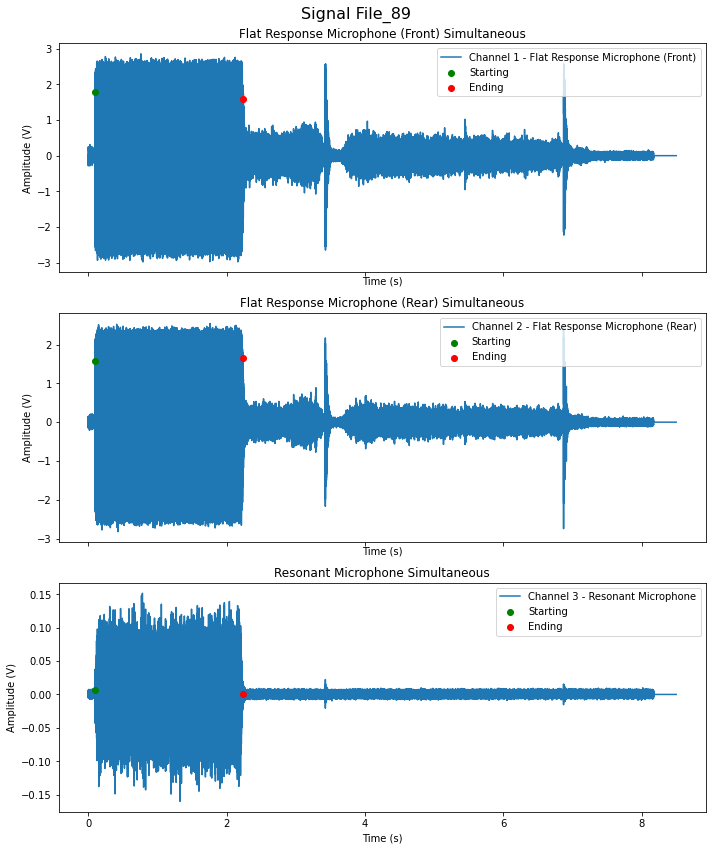

Processing files:  22%|████▉                 | 90/400 [23:14<1:21:11, 15.71s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_90, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_90.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429737.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_90.parquet for Channel 2


Processing files:  23%|█████                 | 91/400 [23:30<1:20:23, 15.61s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428783.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_90.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428783.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_91, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_91.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428038.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_91.parquet for Channel 2


Processing files:  23%|█████                 | 92/400 [23:45<1:19:55, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 426625.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_91.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 426625.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_92, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_92.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430128.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_92.parquet for Channel 2


Processing files:  23%|█████                 | 93/400 [24:00<1:19:17, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429247.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_92.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429247.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_93, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_93.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428849.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_93.parquet for Channel 2


Processing files:  24%|█████▏                | 94/400 [24:16<1:18:48, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 426855.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_93.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 426855.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_94, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_94.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430478.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_94.parquet for Channel 2


Processing files:  24%|█████▏                | 95/400 [24:31<1:18:23, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429523.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_94.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429523.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_95, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_95.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428404.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_95.parquet for Channel 2


Processing files:  24%|█████▎                | 96/400 [24:47<1:18:17, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 428057.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_95.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 428057.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_96, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_96.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430654.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_96.parquet for Channel 2


Processing files:  24%|█████▎                | 97/400 [25:02<1:18:05, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427835.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_96.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427835.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_97, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_97.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 428180.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_97.parquet for Channel 2


Processing files:  24%|█████▍                | 98/400 [25:18<1:18:00, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 427182.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_97.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 427182.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_98, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_98.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 430187.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_98.parquet for Channel 2


Processing files:  25%|█████▍                | 99/400 [25:33<1:17:48, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 429004.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_98.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 429004.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_99, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_99.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 429730.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_99.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 428214.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_99.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segment

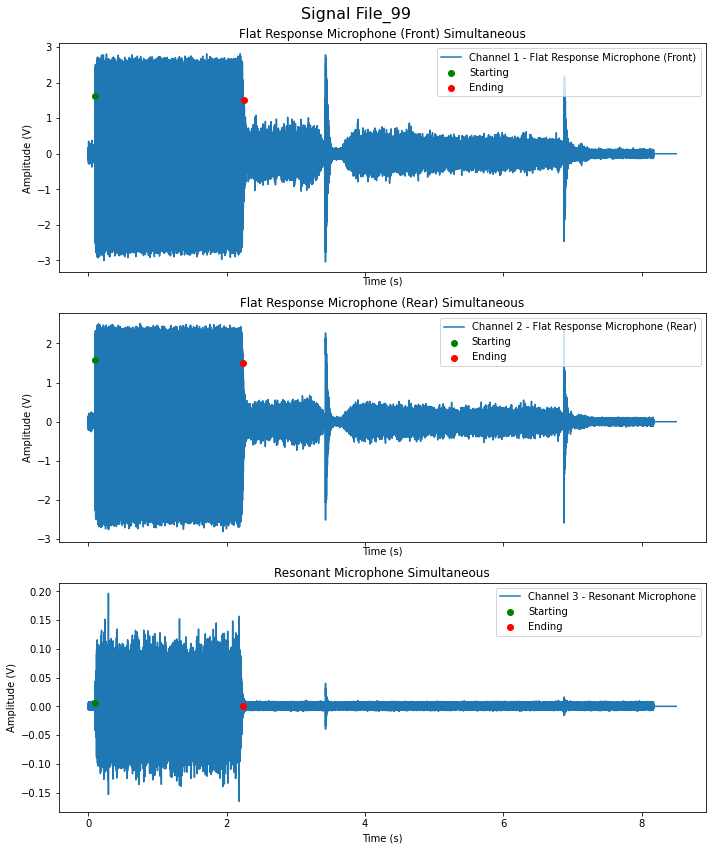

Processing files:  25%|█████▎               | 100/400 [25:50<1:18:53, 15.78s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_100, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_100.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 382617.50, Standard Deviation: 1350.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_100.parquet for Channel 2


Processing files:  25%|█████▎               | 101/400 [26:05<1:18:02, 15.66s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 381100.50, Standard Deviation: 421.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_100.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 381100.50, Standard Deviation: 421.50, Num. segments: 2

Processing File: File_101, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_101.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 380927.00, Standard Deviation: 1083.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_101.parquet for Channel 2


Processing files:  26%|█████▎               | 102/400 [26:20<1:17:22, 15.58s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380137.00, Standard Deviation: 130.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_101.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380137.00, Standard Deviation: 130.00, Num. segments: 2

Processing File: File_102, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_102.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 382442.00, Standard Deviation: 374.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_102.parquet for Channel 2


Processing files:  26%|█████▍               | 103/400 [26:36<1:16:47, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380834.50, Standard Deviation: 95.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_102.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380834.50, Standard Deviation: 95.50, Num. segments: 2

Processing File: File_103, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_103.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381511.50, Standard Deviation: 666.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_103.parquet for Channel 2


Processing files:  26%|█████▍               | 104/400 [26:51<1:16:21, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 379734.00, Standard Deviation: 366.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_103.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 379734.00, Standard Deviation: 366.00, Num. segments: 2

Processing File: File_104, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_104.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 382273.00, Standard Deviation: 255.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_104.parquet for Channel 2


Processing files:  26%|█████▌               | 105/400 [27:07<1:16:01, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 381278.00, Standard Deviation: 206.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_104.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 381278.00, Standard Deviation: 206.00, Num. segments: 2

Processing File: File_105, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_105.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381286.50, Standard Deviation: 938.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_105.parquet for Channel 2


Processing files:  26%|█████▌               | 106/400 [27:22<1:15:38, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380389.50, Standard Deviation: 744.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_105.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380389.50, Standard Deviation: 744.50, Num. segments: 2

Processing File: File_106, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_106.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 383965.50, Standard Deviation: 1400.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_106.parquet for Channel 2


Processing files:  27%|█████▌               | 107/400 [27:38<1:15:36, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 381069.50, Standard Deviation: 689.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_106.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 381069.50, Standard Deviation: 689.50, Num. segments: 2

Processing File: File_107, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_107.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381184.00, Standard Deviation: 512.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_107.parquet for Channel 2


Processing files:  27%|█████▋               | 108/400 [27:53<1:15:30, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380128.00, Standard Deviation: 432.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_107.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380128.00, Standard Deviation: 432.00, Num. segments: 2

Processing File: File_108, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_108.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 383336.50, Standard Deviation: 673.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_108.parquet for Channel 2


Processing files:  27%|█████▋               | 109/400 [28:09<1:15:16, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380483.00, Standard Deviation: 784.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_108.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380483.00, Standard Deviation: 784.00, Num. segments: 2

Processing File: File_109, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_109.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 380949.50, Standard Deviation: 811.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_109.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 380259.50, Standard Deviation: 1273.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_109.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed wi

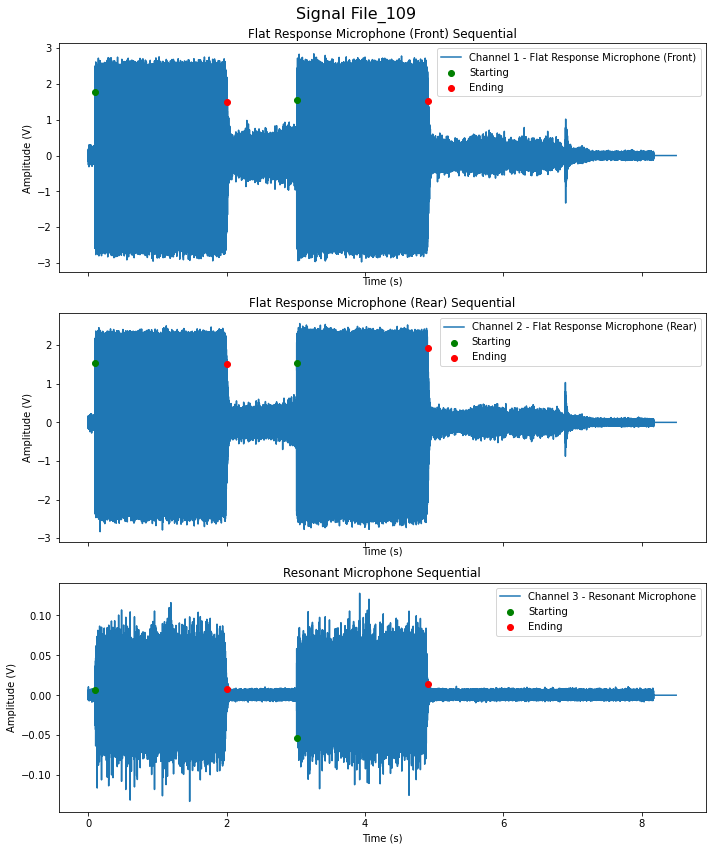

Processing files:  28%|█████▊               | 110/400 [28:25<1:16:25, 15.81s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_110, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_110.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381976.00, Standard Deviation: 615.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_110.parquet for Channel 2


Processing files:  28%|█████▊               | 111/400 [28:41<1:15:28, 15.67s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380856.50, Standard Deviation: 409.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_110.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380856.50, Standard Deviation: 409.50, Num. segments: 2

Processing File: File_111, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_111.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381323.00, Standard Deviation: 1224.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_111.parquet for Channel 2


Processing files:  28%|█████▉               | 112/400 [28:56<1:14:46, 15.58s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380282.50, Standard Deviation: 617.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_111.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380282.50, Standard Deviation: 617.50, Num. segments: 2

Processing File: File_112, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_112.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 382240.00, Standard Deviation: 5.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_112.parquet for Channel 2


Processing files:  28%|█████▉               | 113/400 [29:11<1:14:12, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380268.00, Standard Deviation: 4.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_112.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380268.00, Standard Deviation: 4.00, Num. segments: 2

Processing File: File_113, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_113.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 381056.50, Standard Deviation: 964.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_113.parquet for Channel 2


Processing files:  28%|█████▉               | 114/400 [29:27<1:13:45, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 380431.00, Standard Deviation: 973.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_113.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 380431.00, Standard Deviation: 973.00, Num. segments: 2

Processing File: File_114, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_114.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 382383.00, Standard Deviation: 69.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_114.parquet for Channel 2


Processing files:  29%|██████               | 115/400 [29:42<1:13:20, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 381506.50, Standard Deviation: 654.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_114.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 381506.50, Standard Deviation: 654.50, Num. segments: 2

Processing File: File_115, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_115.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 383591.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_115.parquet for Channel 2


Processing files:  29%|██████               | 116/400 [29:57<1:12:58, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 382854.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_115.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 382854.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_116, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_116.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 386429.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_116.parquet for Channel 2


Processing files:  29%|██████▏              | 117/400 [30:13<1:12:52, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 383816.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_116.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 383816.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_117, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_117.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 383608.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_117.parquet for Channel 2


Processing files:  30%|██████▏              | 118/400 [30:28<1:12:38, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 382476.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_117.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 382476.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_118, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_118.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 386429.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_118.parquet for Channel 2


Processing files:  30%|██████▏              | 119/400 [30:44<1:12:14, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 383535.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_118.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 383535.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_119, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_119.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 384146.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_119.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 381643.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_119.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 se

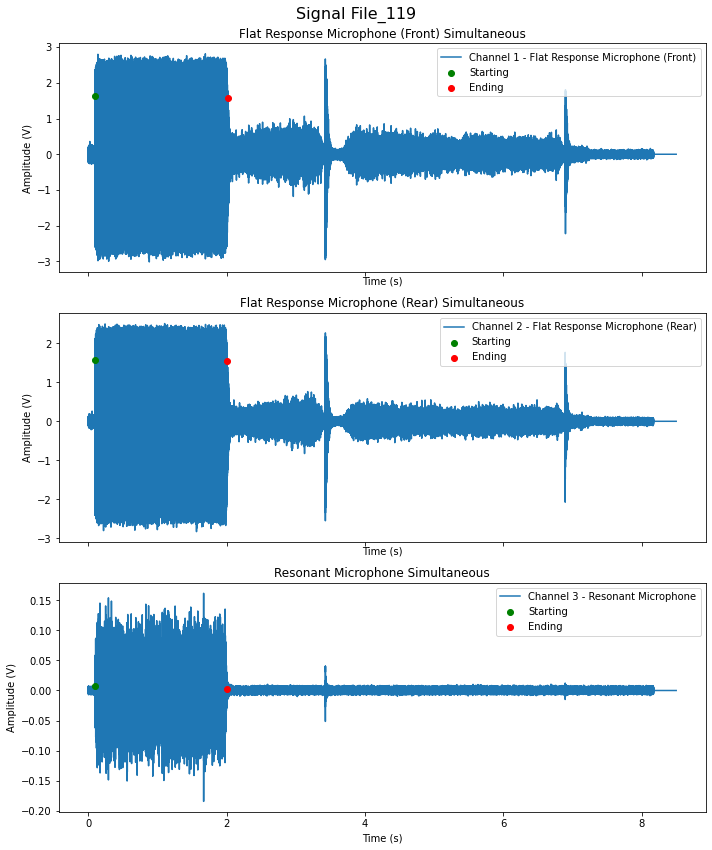

Processing files:  30%|██████▎              | 120/400 [31:00<1:13:06, 15.67s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_120, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_120.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 385691.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_120.parquet for Channel 2


Processing files:  30%|██████▎              | 121/400 [31:15<1:12:25, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 383837.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_120.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 383837.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_121, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_121.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 383990.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_121.parquet for Channel 2


Processing files:  30%|██████▍              | 122/400 [31:31<1:12:07, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 382673.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_121.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 382673.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_122, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_122.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 385654.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_122.parquet for Channel 2


Processing files:  31%|██████▍              | 123/400 [31:46<1:11:52, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 383868.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_122.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 383868.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_123, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_123.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 384148.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_123.parquet for Channel 2


Processing files:  31%|██████▌              | 124/400 [32:02<1:11:36, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 383589.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_123.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 383589.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_124, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_124.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 384661.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_124.parquet for Channel 2


Processing files:  31%|██████▌              | 125/400 [32:18<1:11:12, 15.54s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 384465.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_124.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 384465.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_125, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_125.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 383811.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_125.parquet for Channel 2


Processing files:  32%|██████▌              | 126/400 [32:33<1:10:42, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 382784.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_125.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 382784.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_126, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_126.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 385035.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_126.parquet for Channel 2


Processing files:  32%|██████▋              | 127/400 [32:48<1:10:17, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 384340.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_126.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 384340.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_127, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_127.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 383305.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_127.parquet for Channel 2


Processing files:  32%|██████▋              | 128/400 [33:04<1:09:56, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 382506.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_127.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 382506.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_128, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_128.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 384419.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_128.parquet for Channel 2


Processing files:  32%|██████▊              | 129/400 [33:19<1:09:35, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 383728.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_128.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 383728.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_129, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_129.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 384146.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_129.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 383302.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_129.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 se

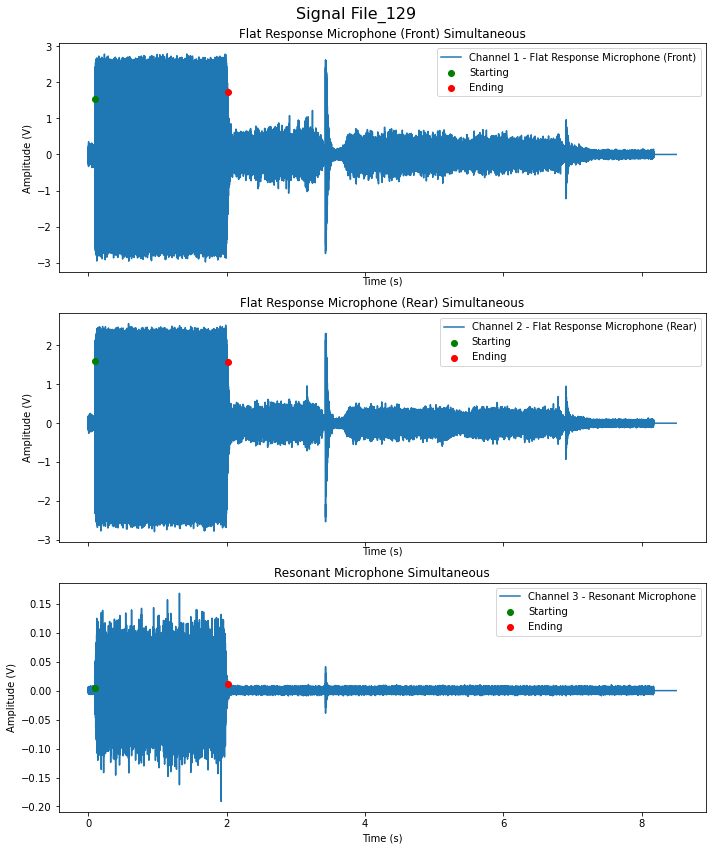

Processing files:  32%|██████▊              | 130/400 [33:35<1:10:28, 15.66s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_130, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_130.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578067.50, Standard Deviation: 93652.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_130.parquet for Channel 2


Processing files:  33%|██████▉              | 131/400 [33:51<1:09:47, 15.57s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576573.50, Standard Deviation: 93749.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_130.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576573.50, Standard Deviation: 93749.50, Num. segments: 2

Processing File: File_131, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_131.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577586.50, Standard Deviation: 93099.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_131.parquet for Channel 2


Processing files:  33%|██████▉              | 132/400 [34:06<1:09:21, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576809.50, Standard Deviation: 93248.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_131.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576809.50, Standard Deviation: 93248.50, Num. segments: 2

Processing File: File_132, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_132.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577628.50, Standard Deviation: 92484.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_132.parquet for Channel 2


Processing files:  33%|██████▉              | 133/400 [34:22<1:09:06, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575343.50, Standard Deviation: 93837.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_132.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575343.50, Standard Deviation: 93837.50, Num. segments: 2

Processing File: File_133, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_133.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577461.00, Standard Deviation: 92651.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_133.parquet for Channel 2


Processing files:  34%|███████              | 134/400 [34:37<1:08:50, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576077.50, Standard Deviation: 92769.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_133.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576077.50, Standard Deviation: 92769.50, Num. segments: 2

Processing File: File_134, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_134.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 576807.50, Standard Deviation: 92763.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_134.parquet for Channel 2


Processing files:  34%|███████              | 135/400 [34:53<1:08:36, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576065.50, Standard Deviation: 93326.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_134.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576065.50, Standard Deviation: 93326.50, Num. segments: 2

Processing File: File_135, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_135.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577947.00, Standard Deviation: 92029.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_135.parquet for Channel 2


Processing files:  34%|███████▏             | 136/400 [35:08<1:08:21, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575368.00, Standard Deviation: 92944.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_135.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575368.00, Standard Deviation: 92944.00, Num. segments: 2

Processing File: File_136, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_136.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577303.50, Standard Deviation: 93142.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_136.parquet for Channel 2


Processing files:  34%|███████▏             | 137/400 [35:24<1:08:09, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576555.00, Standard Deviation: 93733.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_136.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576555.00, Standard Deviation: 93733.00, Num. segments: 2

Processing File: File_137, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_137.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 576435.50, Standard Deviation: 92883.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_137.parquet for Channel 2


Processing files:  34%|███████▏             | 138/400 [35:39<1:07:55, 15.56s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575531.00, Standard Deviation: 92123.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_137.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575531.00, Standard Deviation: 92123.00, Num. segments: 2

Processing File: File_138, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_138.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578047.50, Standard Deviation: 93167.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_138.parquet for Channel 2


Processing files:  35%|███████▎             | 139/400 [35:55<1:07:25, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576749.50, Standard Deviation: 93511.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_138.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576749.50, Standard Deviation: 93511.50, Num. segments: 2

Processing File: File_139, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_139.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577368.50, Standard Deviation: 92640.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_139.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 576582.00, Standard Deviation: 92929.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_139.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processe

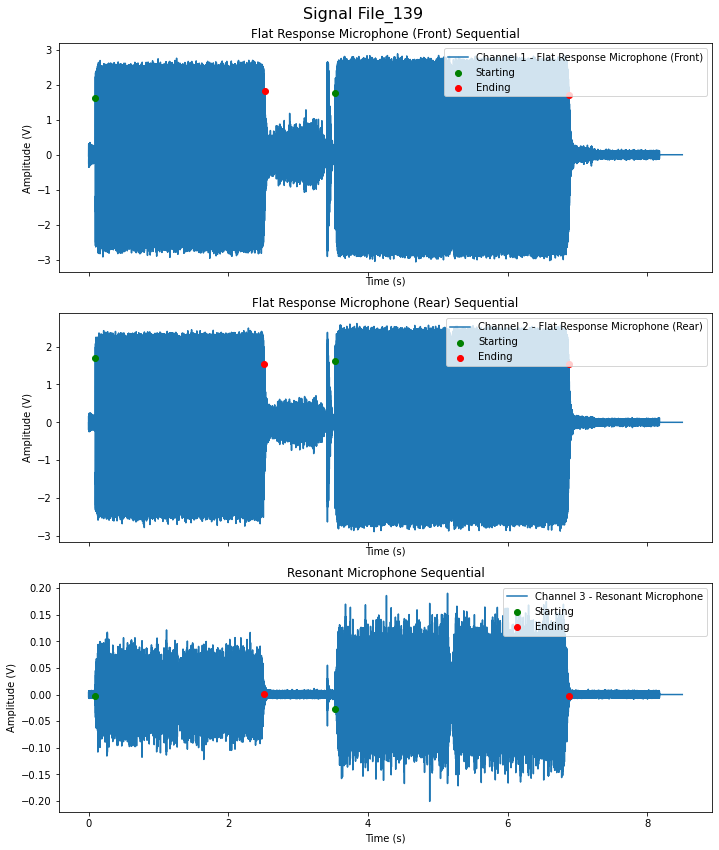

Processing files:  35%|███████▎             | 140/400 [36:11<1:08:31, 15.81s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_140, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_140.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577563.50, Standard Deviation: 92336.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_140.parquet for Channel 2


Processing files:  35%|███████▍             | 141/400 [36:27<1:07:39, 15.67s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576007.00, Standard Deviation: 93118.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_140.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576007.00, Standard Deviation: 93118.00, Num. segments: 2

Processing File: File_141, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_141.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577060.00, Standard Deviation: 92264.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_141.parquet for Channel 2


Processing files:  36%|███████▍             | 142/400 [36:42<1:07:01, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575821.50, Standard Deviation: 92098.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_141.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575821.50, Standard Deviation: 92098.50, Num. segments: 2

Processing File: File_142, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_142.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 576788.00, Standard Deviation: 92493.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_142.parquet for Channel 2


Processing files:  36%|███████▌             | 143/400 [36:57<1:06:35, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575705.00, Standard Deviation: 92478.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_142.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575705.00, Standard Deviation: 92478.00, Num. segments: 2

Processing File: File_143, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_143.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577102.00, Standard Deviation: 92656.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_143.parquet for Channel 2


Processing files:  36%|███████▌             | 144/400 [37:13<1:06:13, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575853.00, Standard Deviation: 92569.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_143.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575853.00, Standard Deviation: 92569.00, Num. segments: 2

Processing File: File_144, Operation: Sequential, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_144.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577089.50, Standard Deviation: 93660.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_144.parquet for Channel 2


Processing files:  36%|███████▌             | 145/400 [37:28<1:05:47, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575938.50, Standard Deviation: 93664.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_144.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575938.50, Standard Deviation: 93664.50, Num. segments: 2

Processing File: File_145, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_145.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672162.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_145.parquet for Channel 2


Processing files:  36%|███████▋             | 146/400 [37:44<1:05:23, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670288.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_145.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670288.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_146, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_146.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673735.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_146.parquet for Channel 2


Processing files:  37%|███████▋             | 147/400 [37:59<1:05:02, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671550.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_146.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671550.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_147, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_147.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672980.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_147.parquet for Channel 2


Processing files:  37%|███████▊             | 148/400 [38:14<1:04:45, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670561.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_147.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670561.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_148, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_148.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673124.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_148.parquet for Channel 2


Processing files:  37%|███████▊             | 149/400 [38:30<1:04:24, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670780.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_148.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670780.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_149, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_149.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672297.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_149.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670759.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_149.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

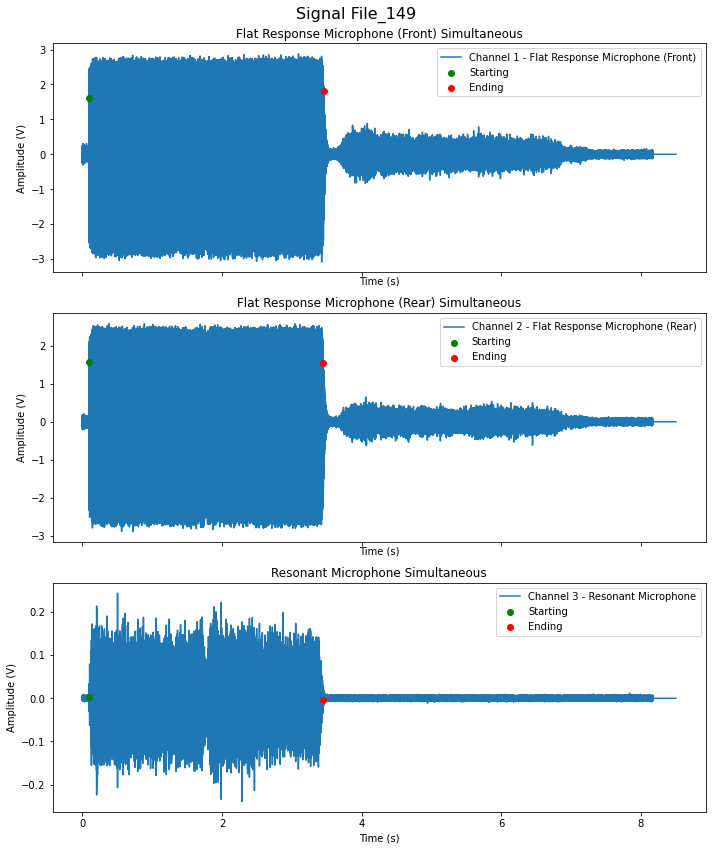

Processing files:  38%|███████▉             | 150/400 [38:46<1:05:13, 15.65s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_150, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_150.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671870.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_150.parquet for Channel 2


Processing files:  38%|███████▉             | 151/400 [39:01<1:04:34, 15.56s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671064.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_150.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671064.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_151, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_151.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673010.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_151.parquet for Channel 2


Processing files:  38%|███████▉             | 152/400 [39:17<1:04:02, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671546.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_151.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671546.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_152, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_152.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673048.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_152.parquet for Channel 2


Processing files:  38%|████████             | 153/400 [39:32<1:03:50, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671261.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_152.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671261.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_153, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_153.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672915.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_153.parquet for Channel 2


Processing files:  38%|████████             | 154/400 [39:48<1:03:31, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671902.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_153.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671902.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_154, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_154.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672012.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_154.parquet for Channel 2


Processing files:  39%|████████▏            | 155/400 [40:03<1:03:17, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671491.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_154.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671491.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_155, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_155.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672283.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_155.parquet for Channel 2


Processing files:  39%|████████▏            | 156/400 [40:19<1:03:06, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672347.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_155.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672347.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_156, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_156.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672776.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_156.parquet for Channel 2


Processing files:  39%|████████▏            | 157/400 [40:34<1:02:53, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671159.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_156.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671159.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_157, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_157.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672464.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_157.parquet for Channel 2


Processing files:  40%|████████▎            | 158/400 [40:50<1:02:40, 15.54s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671852.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_157.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671852.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_158, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_158.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672410.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_158.parquet for Channel 2


Processing files:  40%|████████▎            | 159/400 [41:05<1:02:27, 15.55s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671692.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_158.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671692.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_159, Operation: Simultaneous, Cube 1 Mode: Conduction1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_159.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671925.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_159.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670804.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_159.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

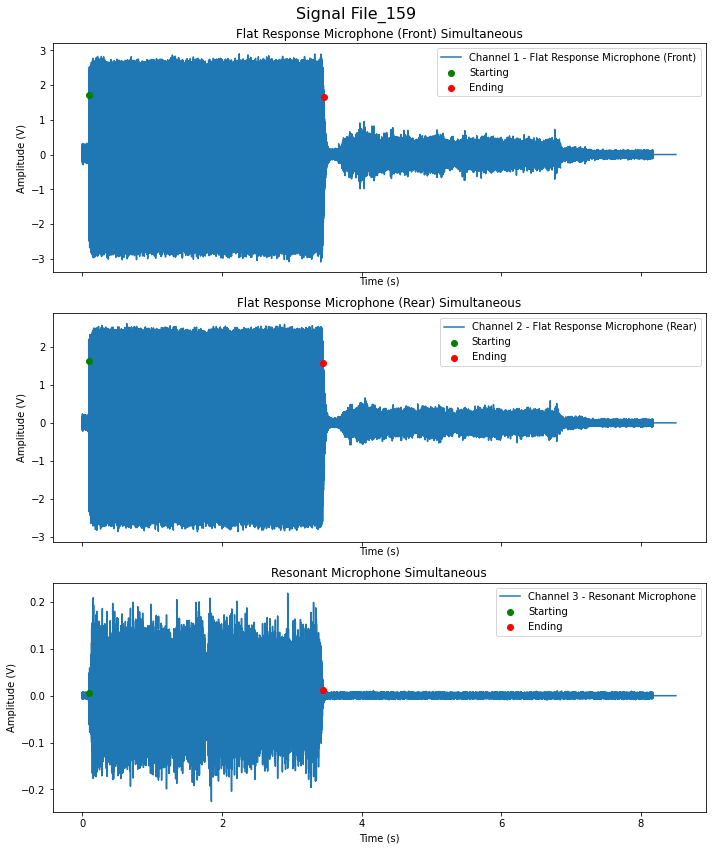

Processing files:  40%|████████▍            | 160/400 [41:22<1:03:20, 15.83s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_160, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_160.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578268.00, Standard Deviation: 93980.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_160.parquet for Channel 2


Processing files:  40%|████████▍            | 161/400 [41:37<1:02:34, 15.71s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576995.50, Standard Deviation: 93684.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_160.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576995.50, Standard Deviation: 93684.50, Num. segments: 2

Processing File: File_161, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_161.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577687.00, Standard Deviation: 95444.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_161.parquet for Channel 2


Processing files:  40%|████████▌            | 162/400 [41:53<1:01:57, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576169.50, Standard Deviation: 94639.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_161.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576169.50, Standard Deviation: 94639.50, Num. segments: 2

Processing File: File_162, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_162.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578296.00, Standard Deviation: 92707.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_162.parquet for Channel 2


Processing files:  41%|████████▌            | 163/400 [42:08<1:01:24, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 577313.00, Standard Deviation: 92342.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_162.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 577313.00, Standard Deviation: 92342.00, Num. segments: 2

Processing File: File_163, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_163.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577747.00, Standard Deviation: 95087.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_163.parquet for Channel 2


Processing files:  41%|████████▌            | 164/400 [42:24<1:00:56, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576406.00, Standard Deviation: 93944.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_163.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576406.00, Standard Deviation: 93944.00, Num. segments: 2

Processing File: File_164, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_164.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578028.00, Standard Deviation: 93641.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_164.parquet for Channel 2


Processing files:  41%|████████▋            | 165/400 [42:39<1:00:32, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576752.50, Standard Deviation: 93089.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_164.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576752.50, Standard Deviation: 93089.50, Num. segments: 2

Processing File: File_165, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_165.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577449.00, Standard Deviation: 93249.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_165.parquet for Channel 2


Processing files:  42%|████████▋            | 166/400 [42:54<1:00:11, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576105.50, Standard Deviation: 94160.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_165.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576105.50, Standard Deviation: 94160.50, Num. segments: 2

Processing File: File_166, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_166.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577995.00, Standard Deviation: 92942.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_166.parquet for Channel 2


Processing files:  42%|█████████▌             | 167/400 [43:10<59:51, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 577105.00, Standard Deviation: 92720.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_166.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 577105.00, Standard Deviation: 92720.00, Num. segments: 2

Processing File: File_167, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_167.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577061.00, Standard Deviation: 93768.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_167.parquet for Channel 2


Processing files:  42%|█████████▋             | 168/400 [43:25<59:33, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 575860.50, Standard Deviation: 93817.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_167.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 575860.50, Standard Deviation: 93817.50, Num. segments: 2

Processing File: File_168, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_168.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578095.00, Standard Deviation: 93340.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_168.parquet for Channel 2


Processing files:  42%|█████████▋             | 169/400 [43:40<59:16, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 577030.50, Standard Deviation: 92676.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_168.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 577030.50, Standard Deviation: 92676.50, Num. segments: 2

Processing File: File_169, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_169.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 576978.50, Standard Deviation: 94406.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_169.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 576163.50, Standard Deviation: 94031.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_169.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processe

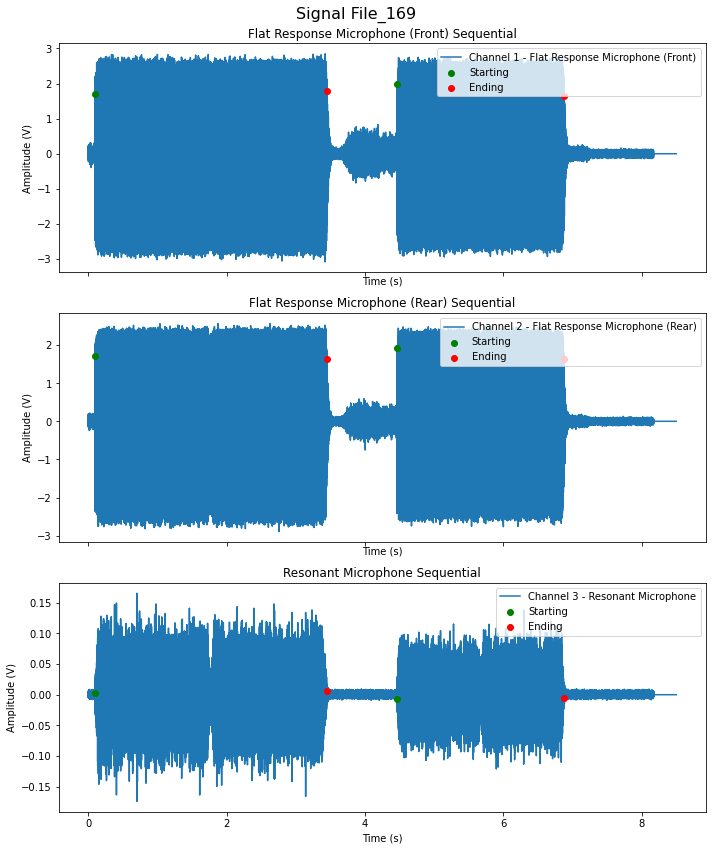

Processing files:  42%|████████▉            | 170/400 [43:57<1:00:18, 15.73s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_170, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_170.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578192.00, Standard Deviation: 92811.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_170.parquet for Channel 2


Processing files:  43%|█████████▊             | 171/400 [44:12<59:37, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576518.50, Standard Deviation: 92601.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_170.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576518.50, Standard Deviation: 92601.50, Num. segments: 2

Processing File: File_171, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_171.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577120.00, Standard Deviation: 93668.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_171.parquet for Channel 2


Processing files:  43%|█████████▉             | 172/400 [44:28<59:02, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576075.50, Standard Deviation: 93919.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_171.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576075.50, Standard Deviation: 93919.50, Num. segments: 2

Processing File: File_172, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_172.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 578193.00, Standard Deviation: 92407.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_172.parquet for Channel 2


Processing files:  43%|█████████▉             | 173/400 [44:43<58:34, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576670.50, Standard Deviation: 92607.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_172.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576670.50, Standard Deviation: 92607.50, Num. segments: 2

Processing File: File_173, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_173.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577185.50, Standard Deviation: 94345.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_173.parquet for Channel 2


Processing files:  44%|██████████             | 174/400 [44:59<58:22, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 576100.50, Standard Deviation: 94123.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_173.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 576100.50, Standard Deviation: 94123.50, Num. segments: 2

Processing File: File_174, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_174.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 577948.50, Standard Deviation: 93186.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_174.parquet for Channel 2


Processing files:  44%|██████████             | 175/400 [45:14<58:11, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 577121.50, Standard Deviation: 92338.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_174.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 577121.50, Standard Deviation: 92338.50, Num. segments: 2

Processing File: File_175, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_175.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672567.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_175.parquet for Channel 2


Processing files:  44%|██████████             | 176/400 [45:30<57:57, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671094.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_175.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671094.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_176, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_176.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670480.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_176.parquet for Channel 2


Processing files:  44%|██████████▏            | 177/400 [45:45<57:44, 15.54s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670381.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_176.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670381.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_177, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_177.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673287.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_177.parquet for Channel 2


Processing files:  44%|██████████▏            | 178/400 [46:01<57:31, 15.55s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670460.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_177.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670460.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_178, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_178.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670587.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_178.parquet for Channel 2


Processing files:  45%|██████████▎            | 179/400 [46:16<57:16, 15.55s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669142.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_178.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669142.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_179, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_179.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671360.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_179.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 669662.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_179.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

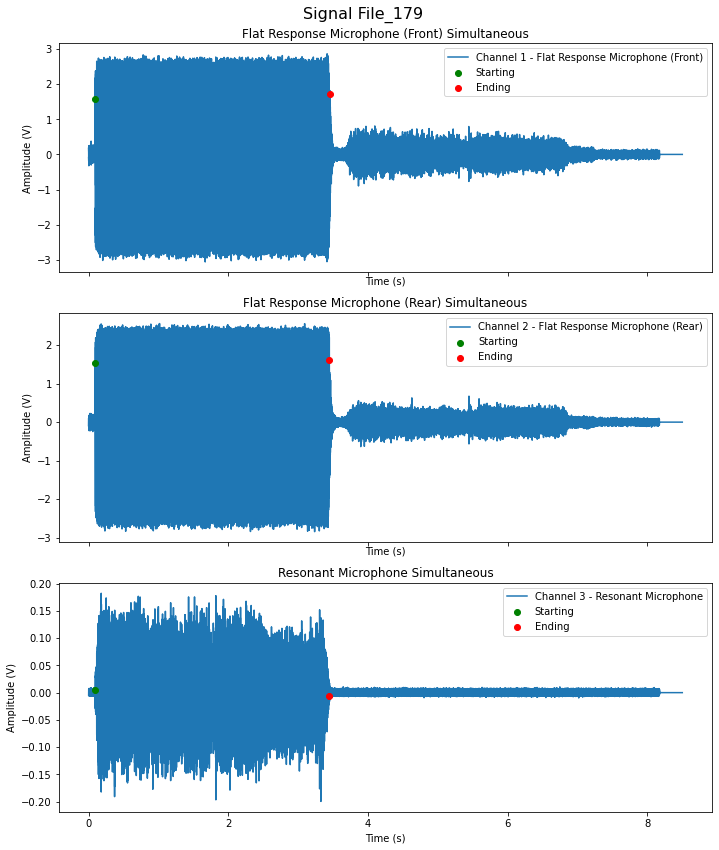

Processing files:  45%|██████████▎            | 180/400 [46:33<58:05, 15.84s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_180, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_180.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671366.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_180.parquet for Channel 2


Processing files:  45%|██████████▍            | 181/400 [46:48<57:30, 15.76s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669783.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_180.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669783.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_181, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_181.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671593.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_181.parquet for Channel 2


Processing files:  46%|██████████▍            | 182/400 [47:04<57:03, 15.70s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670993.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_181.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670993.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_182, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_182.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670206.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_182.parquet for Channel 2


Processing files:  46%|██████████▌            | 183/400 [47:19<56:31, 15.63s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670370.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_182.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670370.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_183, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_183.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672499.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_183.parquet for Channel 2


Processing files:  46%|██████████▌            | 184/400 [47:35<56:04, 15.58s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670535.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_183.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670535.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_184, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_184.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670888.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_184.parquet for Channel 2


Processing files:  46%|██████████▋            | 185/400 [47:50<55:42, 15.55s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669299.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_184.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669299.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_185, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_185.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672558.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_185.parquet for Channel 2


Processing files:  46%|██████████▋            | 186/400 [48:06<55:15, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669563.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_185.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669563.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_186, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_186.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 669944.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_186.parquet for Channel 2


Processing files:  47%|██████████▊            | 187/400 [48:21<54:52, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670442.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_186.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670442.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_187, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_187.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673024.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_187.parquet for Channel 2


Processing files:  47%|██████████▊            | 188/400 [48:37<54:33, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670627.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_187.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670627.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_188, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_188.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670658.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_188.parquet for Channel 2


Processing files:  47%|██████████▊            | 189/400 [48:52<54:12, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669165.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_188.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669165.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_189, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Conduction1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_189.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672162.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_189.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670080.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_189.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

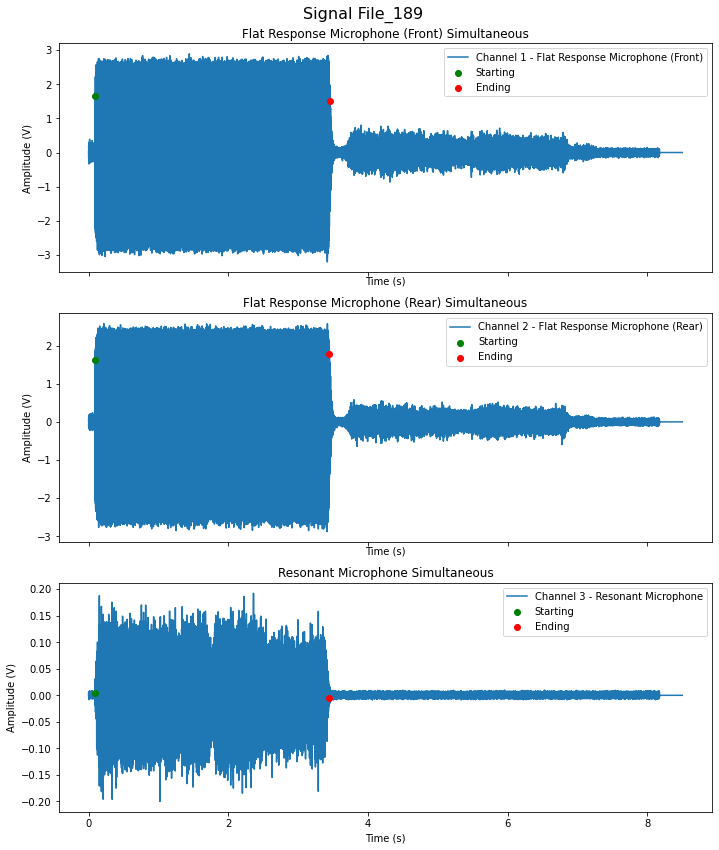

Processing files:  48%|██████████▉            | 190/400 [49:08<54:50, 15.67s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_190, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_190.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549149.00, Standard Deviation: 122496.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_190.parquet for Channel 2


Processing files:  48%|██████████▉            | 191/400 [49:23<54:14, 15.57s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547572.50, Standard Deviation: 122810.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_190.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547572.50, Standard Deviation: 122810.50, Num. segments: 2

Processing File: File_191, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_191.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549553.00, Standard Deviation: 122418.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_191.parquet for Channel 2


Processing files:  48%|███████████            | 192/400 [49:39<53:44, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547245.50, Standard Deviation: 122600.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_191.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547245.50, Standard Deviation: 122600.50, Num. segments: 2

Processing File: File_192, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_192.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548558.50, Standard Deviation: 122164.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_192.parquet for Channel 2


Processing files:  48%|███████████            | 193/400 [49:54<53:20, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547811.00, Standard Deviation: 122173.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_192.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547811.00, Standard Deviation: 122173.00, Num. segments: 2

Processing File: File_193, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_193.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548072.00, Standard Deviation: 121629.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_193.parquet for Channel 2


Processing files:  48%|███████████▏           | 194/400 [50:10<53:09, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547157.50, Standard Deviation: 121186.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_193.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547157.50, Standard Deviation: 121186.50, Num. segments: 2

Processing File: File_194, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_194.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548765.00, Standard Deviation: 121299.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_194.parquet for Channel 2


Processing files:  49%|███████████▏           | 195/400 [50:25<52:47, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547717.00, Standard Deviation: 122493.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_194.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547717.00, Standard Deviation: 122493.00, Num. segments: 2

Processing File: File_195, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_195.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548727.50, Standard Deviation: 121736.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_195.parquet for Channel 2


Processing files:  49%|███████████▎           | 196/400 [50:40<52:27, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 546661.00, Standard Deviation: 121799.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_195.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 546661.00, Standard Deviation: 121799.00, Num. segments: 2

Processing File: File_196, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_196.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548580.00, Standard Deviation: 122206.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_196.parquet for Channel 2


Processing files:  49%|███████████▎           | 197/400 [50:56<52:08, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547382.50, Standard Deviation: 122215.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_196.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547382.50, Standard Deviation: 122215.50, Num. segments: 2

Processing File: File_197, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_197.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548782.50, Standard Deviation: 121237.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_197.parquet for Channel 2


Processing files:  50%|███████████▍           | 198/400 [51:11<51:51, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 546835.00, Standard Deviation: 122027.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_197.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 546835.00, Standard Deviation: 122027.00, Num. segments: 2

Processing File: File_198, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_198.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548843.00, Standard Deviation: 121822.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_198.parquet for Channel 2


Processing files:  50%|███████████▍           | 199/400 [51:27<51:33, 15.39s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547224.00, Standard Deviation: 122083.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_198.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547224.00, Standard Deviation: 122083.00, Num. segments: 2

Processing File: File_199, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_199.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548167.50, Standard Deviation: 121921.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_199.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 547056.50, Standard Deviation: 121652.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_199.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Proc

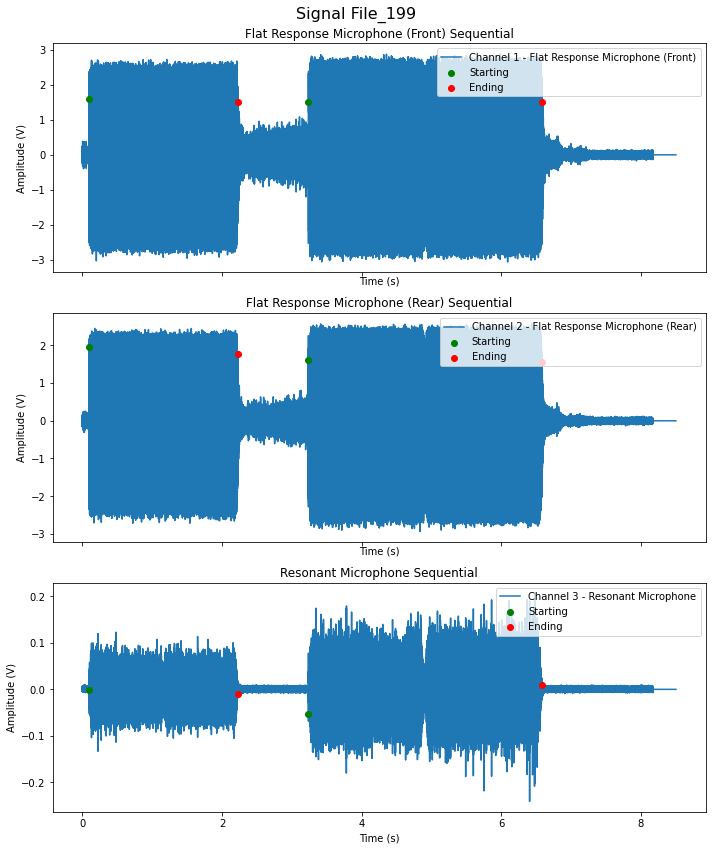

Processing files:  50%|███████████▌           | 200/400 [51:43<52:30, 15.75s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_200, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_200.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548672.50, Standard Deviation: 121742.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_200.parquet for Channel 2


Processing files:  50%|███████████▌           | 201/400 [51:59<51:57, 15.67s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547050.50, Standard Deviation: 121996.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_200.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547050.50, Standard Deviation: 121996.50, Num. segments: 2

Processing File: File_201, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_201.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548282.50, Standard Deviation: 121125.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_201.parquet for Channel 2


Processing files:  50%|███████████▌           | 202/400 [52:14<51:25, 15.58s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 546784.50, Standard Deviation: 121829.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_201.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 546784.50, Standard Deviation: 121829.50, Num. segments: 2

Processing File: File_202, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_202.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548478.50, Standard Deviation: 121863.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_202.parquet for Channel 2


Processing files:  51%|███████████▋           | 203/400 [52:29<50:57, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547922.00, Standard Deviation: 122454.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_202.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547922.00, Standard Deviation: 122454.00, Num. segments: 2

Processing File: File_203, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_203.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548730.00, Standard Deviation: 121606.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_203.parquet for Channel 2


Processing files:  51%|███████████▋           | 204/400 [52:45<50:33, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547098.00, Standard Deviation: 121720.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_203.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547098.00, Standard Deviation: 121720.00, Num. segments: 2

Processing File: File_204, Operation: Sequential, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_204.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548318.50, Standard Deviation: 122357.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_204.parquet for Channel 2


Processing files:  51%|███████████▊           | 205/400 [53:00<50:13, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547292.50, Standard Deviation: 121919.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_204.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547292.50, Standard Deviation: 121919.50, Num. segments: 2

Processing File: File_205, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_205.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672674.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_205.parquet for Channel 2


Processing files:  52%|███████████▊           | 206/400 [53:16<50:01, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670317.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_205.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670317.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_206, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_206.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672538.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_206.parquet for Channel 2


Processing files:  52%|███████████▉           | 207/400 [53:31<49:48, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671448.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_206.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671448.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_207, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_207.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673149.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_207.parquet for Channel 2


Processing files:  52%|███████████▉           | 208/400 [53:47<49:26, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672108.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_207.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672108.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_208, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_208.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672215.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_208.parquet for Channel 2


Processing files:  52%|████████████           | 209/400 [54:02<49:12, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671863.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_208.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671863.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_209, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_209.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673015.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_209.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671390.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_209.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

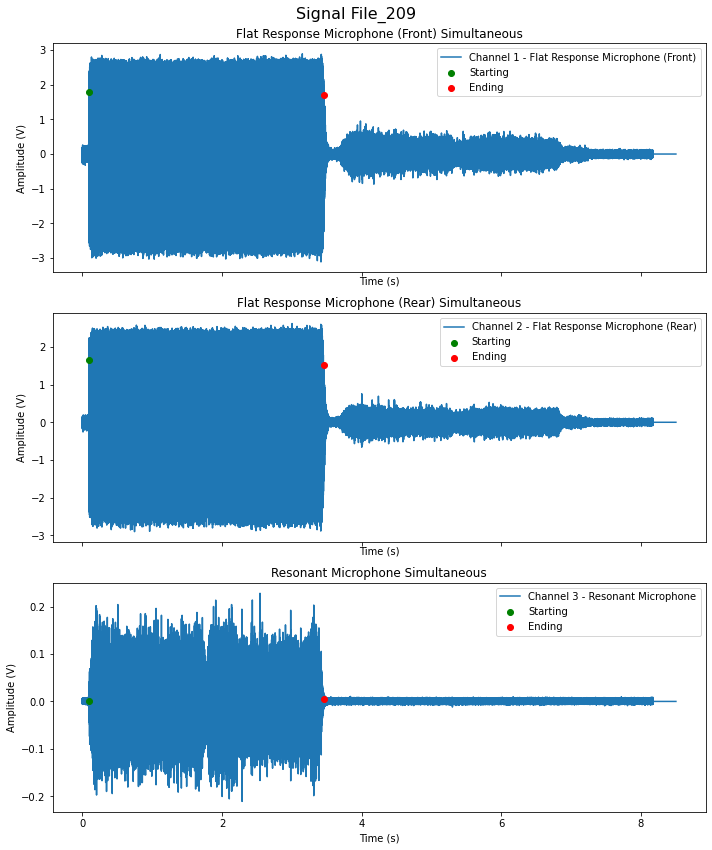

Processing files:  52%|████████████           | 210/400 [54:19<49:56, 15.77s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_210, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_210.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672563.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_210.parquet for Channel 2


Processing files:  53%|████████████▏          | 211/400 [54:34<49:22, 15.68s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670981.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_210.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670981.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_211, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_211.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672535.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_211.parquet for Channel 2


Processing files:  53%|████████████▏          | 212/400 [54:49<48:55, 15.61s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670963.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_211.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670963.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_212, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_212.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672374.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_212.parquet for Channel 2


Processing files:  53%|████████████▏          | 213/400 [55:05<48:31, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671888.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_212.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671888.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_213, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_213.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672159.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_213.parquet for Channel 2


Processing files:  54%|████████████▎          | 214/400 [55:20<48:02, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671604.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_213.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671604.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_214, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_214.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672949.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_214.parquet for Channel 2


Processing files:  54%|████████████▎          | 215/400 [55:36<47:49, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671239.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_214.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671239.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_215, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_215.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672479.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_215.parquet for Channel 2


Processing files:  54%|████████████▍          | 216/400 [55:51<47:32, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670732.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_215.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670732.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_216, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_216.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672788.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_216.parquet for Channel 2


Processing files:  54%|████████████▍          | 217/400 [56:07<47:17, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671477.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_216.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671477.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_217, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_217.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673302.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_217.parquet for Channel 2


Processing files:  55%|████████████▌          | 218/400 [56:22<47:02, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671454.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_217.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671454.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_218, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_218.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672266.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_218.parquet for Channel 2


Processing files:  55%|████████████▌          | 219/400 [56:38<46:46, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671103.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_218.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671103.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_219, Operation: Simultaneous, Cube 1 Mode: Conduction2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_219.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672797.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_219.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671459.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_219.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

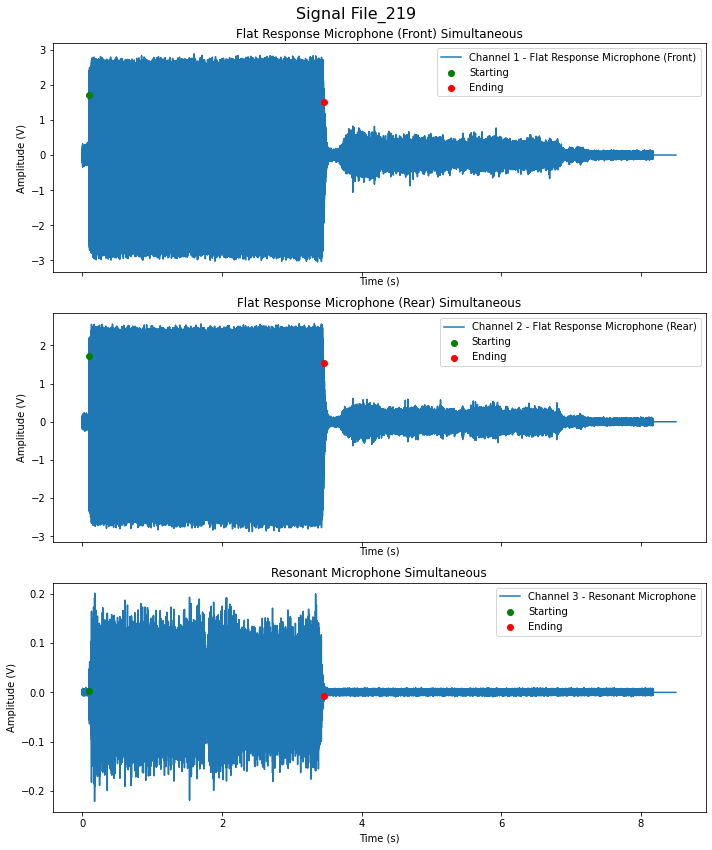

Processing files:  55%|████████████▋          | 220/400 [56:54<47:26, 15.82s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_220, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_220.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549661.00, Standard Deviation: 122241.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_220.parquet for Channel 2


Processing files:  55%|████████████▋          | 221/400 [57:10<46:51, 15.71s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547938.50, Standard Deviation: 123194.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_220.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547938.50, Standard Deviation: 123194.50, Num. segments: 2

Processing File: File_221, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_221.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548865.50, Standard Deviation: 123757.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_221.parquet for Channel 2


Processing files:  56%|████████████▊          | 222/400 [57:25<46:27, 15.66s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547771.00, Standard Deviation: 123571.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_221.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547771.00, Standard Deviation: 123571.00, Num. segments: 2

Processing File: File_222, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_222.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549230.50, Standard Deviation: 121916.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_222.parquet for Channel 2


Processing files:  56%|████████████▊          | 223/400 [57:41<46:06, 15.63s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547596.50, Standard Deviation: 121987.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_222.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547596.50, Standard Deviation: 121987.50, Num. segments: 2

Processing File: File_223, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_223.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548773.50, Standard Deviation: 123816.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_223.parquet for Channel 2


Processing files:  56%|████████████▉          | 224/400 [57:56<45:37, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 546970.50, Standard Deviation: 122801.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_223.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 546970.50, Standard Deviation: 122801.50, Num. segments: 2

Processing File: File_224, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_224.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548746.00, Standard Deviation: 121148.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_224.parquet for Channel 2


Processing files:  56%|████████████▉          | 225/400 [58:12<45:16, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547636.50, Standard Deviation: 121555.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_224.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547636.50, Standard Deviation: 121555.50, Num. segments: 2

Processing File: File_225, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_225.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548528.50, Standard Deviation: 123354.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_225.parquet for Channel 2


Processing files:  56%|████████████▉          | 226/400 [58:27<44:53, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 546943.00, Standard Deviation: 122851.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_225.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 546943.00, Standard Deviation: 122851.00, Num. segments: 2

Processing File: File_226, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_226.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549767.00, Standard Deviation: 122219.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_226.parquet for Channel 2


Processing files:  57%|█████████████          | 227/400 [58:43<44:32, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 548576.50, Standard Deviation: 122394.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_226.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 548576.50, Standard Deviation: 122394.50, Num. segments: 2

Processing File: File_227, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_227.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548815.50, Standard Deviation: 123216.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_227.parquet for Channel 2


Processing files:  57%|█████████████          | 228/400 [58:58<44:15, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547179.50, Standard Deviation: 122649.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_227.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547179.50, Standard Deviation: 122649.50, Num. segments: 2

Processing File: File_228, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_228.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549657.50, Standard Deviation: 121482.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_228.parquet for Channel 2


Processing files:  57%|█████████████▏         | 229/400 [59:13<43:54, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547868.50, Standard Deviation: 122042.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_228.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547868.50, Standard Deviation: 122042.50, Num. segments: 2

Processing File: File_229, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_229.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548877.00, Standard Deviation: 123634.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_229.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 546335.00, Standard Deviation: 122855.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_229.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Proc

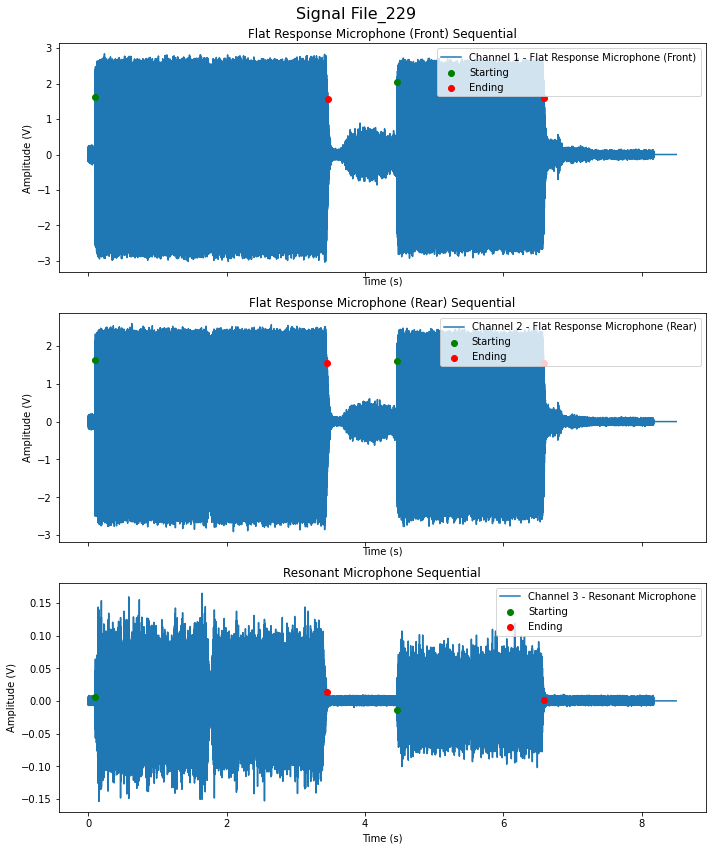

Processing files:  57%|█████████████▏         | 230/400 [59:30<44:35, 15.74s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_230, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_230.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548899.50, Standard Deviation: 121481.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_230.parquet for Channel 2


Processing files:  58%|█████████████▎         | 231/400 [59:45<43:59, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 548187.50, Standard Deviation: 121583.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_230.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 548187.50, Standard Deviation: 121583.50, Num. segments: 2

Processing File: File_231, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_231.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548760.50, Standard Deviation: 123588.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_231.parquet for Channel 2


Processing files:  58%|████████████▏        | 232/400 [1:00:00<43:30, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547525.00, Standard Deviation: 122474.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_231.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547525.00, Standard Deviation: 122474.00, Num. segments: 2

Processing File: File_232, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_232.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548802.50, Standard Deviation: 121624.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_232.parquet for Channel 2


Processing files:  58%|████████████▏        | 233/400 [1:00:16<43:05, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 548909.50, Standard Deviation: 121678.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_232.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 548909.50, Standard Deviation: 121678.50, Num. segments: 2

Processing File: File_233, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_233.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 548430.00, Standard Deviation: 123417.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_233.parquet for Channel 2


Processing files:  58%|████████████▎        | 234/400 [1:00:31<42:44, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547428.50, Standard Deviation: 123375.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_233.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547428.50, Standard Deviation: 123375.50, Num. segments: 2

Processing File: File_234, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_234.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 549123.50, Standard Deviation: 121860.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_234.parquet for Channel 2


Processing files:  59%|████████████▎        | 235/400 [1:00:47<42:25, 15.43s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 547940.50, Standard Deviation: 121917.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_234.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 547940.50, Standard Deviation: 121917.50, Num. segments: 2

Processing File: File_235, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_235.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673249.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_235.parquet for Channel 2


Processing files:  59%|████████████▍        | 236/400 [1:01:02<42:15, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670739.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_235.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670739.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_236, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_236.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670926.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_236.parquet for Channel 2


Processing files:  59%|████████████▍        | 237/400 [1:01:17<41:55, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670244.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_236.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670244.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_237, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_237.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670547.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_237.parquet for Channel 2


Processing files:  60%|████████████▍        | 238/400 [1:01:33<41:37, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670181.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_237.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670181.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_238, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_238.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671048.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_238.parquet for Channel 2


Processing files:  60%|████████████▌        | 239/400 [1:01:48<41:19, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669307.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_238.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669307.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_239, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_239.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673147.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_239.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 669659.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_239.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

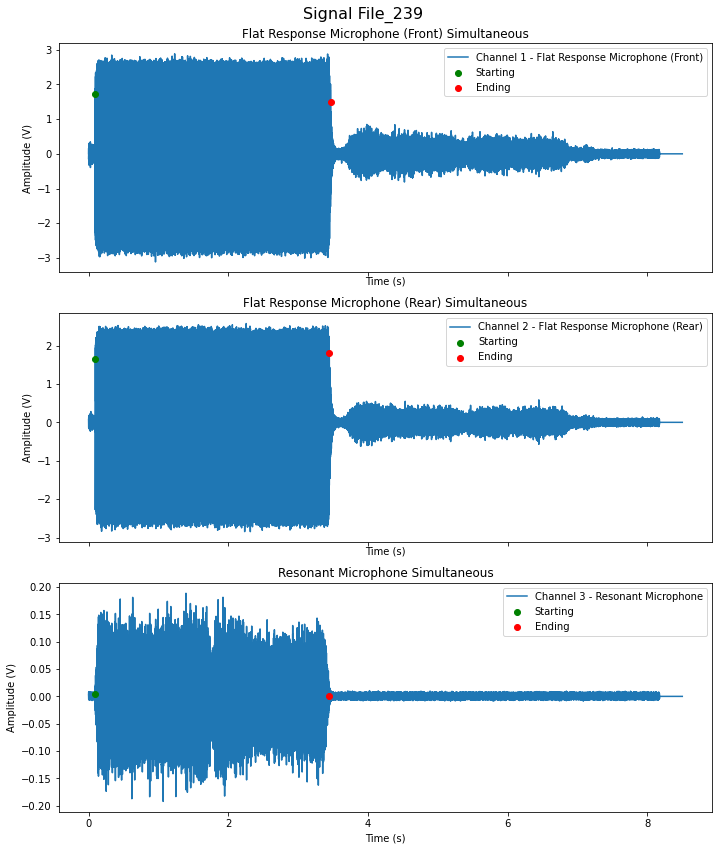

Processing files:  60%|████████████▌        | 240/400 [1:02:05<41:48, 15.68s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_240, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_240.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670881.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_240.parquet for Channel 2


Processing files:  60%|████████████▋        | 241/400 [1:02:20<41:17, 15.58s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669415.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_240.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669415.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_241, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_241.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671333.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_241.parquet for Channel 2


Processing files:  60%|████████████▋        | 242/400 [1:02:35<40:51, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670911.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_241.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670911.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_242, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_242.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671351.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_242.parquet for Channel 2


Processing files:  61%|████████████▊        | 243/400 [1:02:51<40:29, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669658.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_242.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669658.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_243, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_243.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672193.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_243.parquet for Channel 2


Processing files:  61%|████████████▊        | 244/400 [1:03:06<40:14, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670332.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_243.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670332.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_244, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_244.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671746.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_244.parquet for Channel 2


Processing files:  61%|████████████▊        | 245/400 [1:03:22<40:02, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670270.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_244.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670270.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_245, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_245.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672318.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_245.parquet for Channel 2


Processing files:  62%|████████████▉        | 246/400 [1:03:37<39:50, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669712.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_245.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669712.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_246, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_246.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670521.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_246.parquet for Channel 2


Processing files:  62%|████████████▉        | 247/400 [1:03:53<39:30, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668936.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_246.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668936.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_247, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_247.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670438.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_247.parquet for Channel 2


Processing files:  62%|█████████████        | 248/400 [1:04:08<39:09, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669923.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_247.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669923.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_248, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_248.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 669831.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_248.parquet for Channel 2


Processing files:  62%|█████████████        | 249/400 [1:04:23<38:49, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669921.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_248.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669921.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_249, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Conduction2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_249.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672768.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_249.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671190.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_249.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

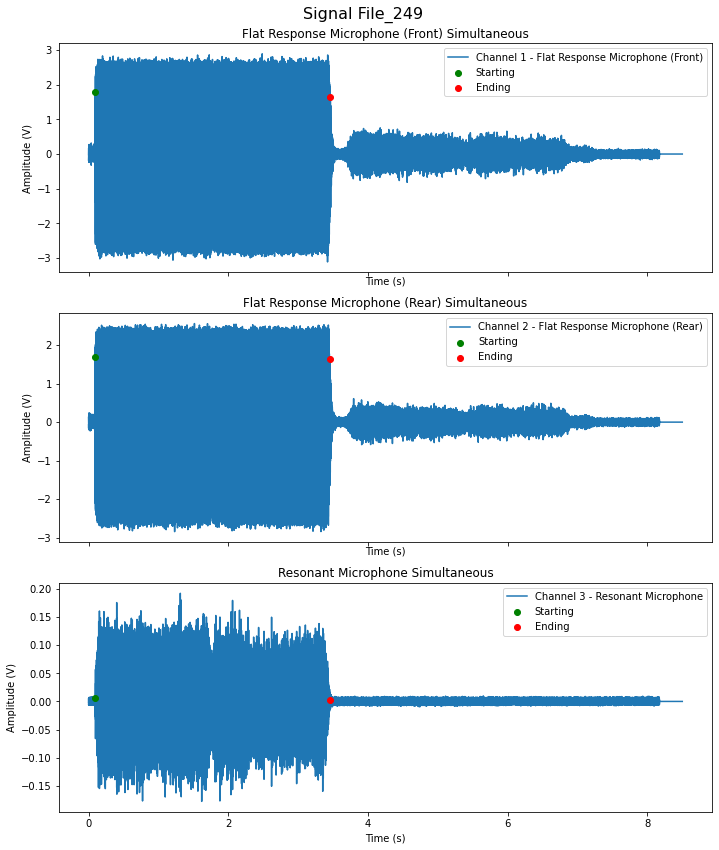

Processing files:  62%|█████████████▏       | 250/400 [1:04:40<39:15, 15.70s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_250, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_250.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526789.50, Standard Deviation: 145843.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_250.parquet for Channel 2


Processing files:  63%|█████████████▏       | 251/400 [1:04:55<38:43, 15.60s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525840.50, Standard Deviation: 145339.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_250.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525840.50, Standard Deviation: 145339.50, Num. segments: 2

Processing File: File_251, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_251.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526553.50, Standard Deviation: 144835.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_251.parquet for Channel 2


Processing files:  63%|█████████████▏       | 252/400 [1:05:11<38:27, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524499.50, Standard Deviation: 144720.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_251.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524499.50, Standard Deviation: 144720.50, Num. segments: 2

Processing File: File_252, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_252.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526029.00, Standard Deviation: 144484.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_252.parquet for Channel 2


Processing files:  63%|█████████████▎       | 253/400 [1:05:26<38:04, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524986.00, Standard Deviation: 144675.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_252.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524986.00, Standard Deviation: 144675.00, Num. segments: 2

Processing File: File_253, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_253.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525806.00, Standard Deviation: 143983.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_253.parquet for Channel 2


Processing files:  64%|█████████████▎       | 254/400 [1:05:41<37:39, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525110.00, Standard Deviation: 144484.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_253.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525110.00, Standard Deviation: 144484.00, Num. segments: 2

Processing File: File_254, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_254.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525683.00, Standard Deviation: 144059.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_254.parquet for Channel 2


Processing files:  64%|█████████████▍       | 255/400 [1:05:57<37:18, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524726.50, Standard Deviation: 143911.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_254.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524726.50, Standard Deviation: 143911.50, Num. segments: 2

Processing File: File_255, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_255.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526446.00, Standard Deviation: 143932.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_255.parquet for Channel 2


Processing files:  64%|█████████████▍       | 256/400 [1:06:12<36:59, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524393.00, Standard Deviation: 143819.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_255.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524393.00, Standard Deviation: 143819.00, Num. segments: 2

Processing File: File_256, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_256.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525698.50, Standard Deviation: 144455.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_256.parquet for Channel 2


Processing files:  64%|█████████████▍       | 257/400 [1:06:27<36:42, 15.40s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525224.00, Standard Deviation: 144815.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_256.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525224.00, Standard Deviation: 144815.00, Num. segments: 2

Processing File: File_257, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_257.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525806.00, Standard Deviation: 143740.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_257.parquet for Channel 2


Processing files:  64%|█████████████▌       | 258/400 [1:06:43<36:29, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524258.00, Standard Deviation: 144333.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_257.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524258.00, Standard Deviation: 144333.00, Num. segments: 2

Processing File: File_258, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_258.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526948.00, Standard Deviation: 143857.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_258.parquet for Channel 2


Processing files:  65%|█████████████▌       | 259/400 [1:06:59<36:19, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525043.50, Standard Deviation: 144604.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_258.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525043.50, Standard Deviation: 144604.50, Num. segments: 2

Processing File: File_259, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_259.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525644.50, Standard Deviation: 144068.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_259.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 524498.50, Standard Deviation: 144578.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_259.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Proc

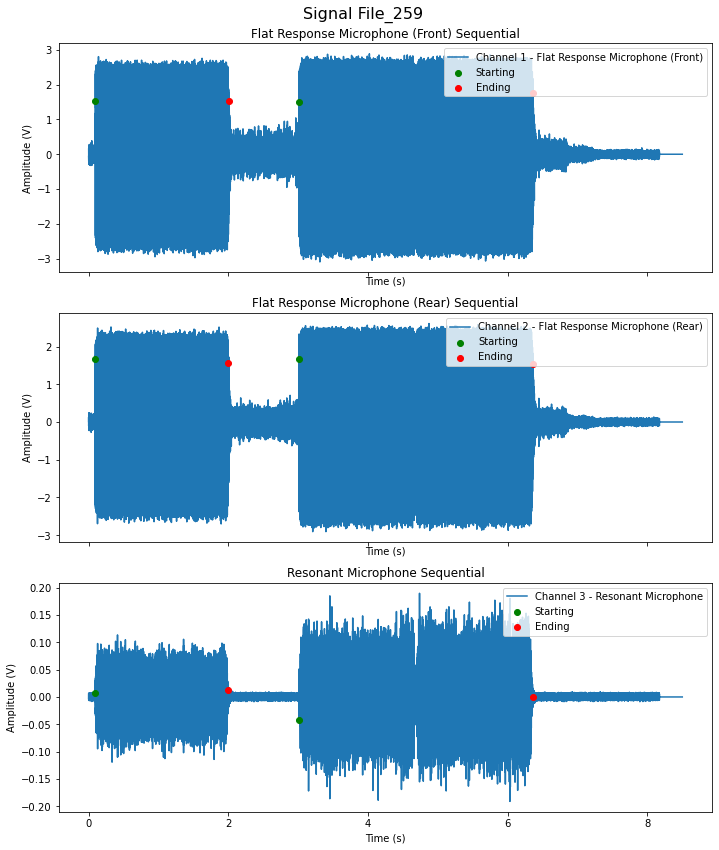

Processing files:  65%|█████████████▋       | 260/400 [1:07:15<36:47, 15.77s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_260, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_260.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526199.00, Standard Deviation: 144424.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_260.parquet for Channel 2


Processing files:  65%|█████████████▋       | 261/400 [1:07:30<36:19, 15.68s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525125.00, Standard Deviation: 144422.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_260.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525125.00, Standard Deviation: 144422.00, Num. segments: 2

Processing File: File_261, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_261.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526034.00, Standard Deviation: 144432.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_261.parquet for Channel 2


Processing files:  66%|█████████████▊       | 262/400 [1:07:46<35:50, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524690.50, Standard Deviation: 144247.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_261.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524690.50, Standard Deviation: 144247.50, Num. segments: 2

Processing File: File_262, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_262.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525942.50, Standard Deviation: 144550.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_262.parquet for Channel 2


Processing files:  66%|█████████████▊       | 263/400 [1:08:01<35:26, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525454.00, Standard Deviation: 145054.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_262.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525454.00, Standard Deviation: 145054.00, Num. segments: 2

Processing File: File_263, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_263.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526897.50, Standard Deviation: 144056.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_263.parquet for Channel 2


Processing files:  66%|█████████████▊       | 264/400 [1:08:17<35:04, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524623.50, Standard Deviation: 144132.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_263.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524623.50, Standard Deviation: 144132.50, Num. segments: 2

Processing File: File_264, Operation: Sequential, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_264.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525770.00, Standard Deviation: 143705.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_264.parquet for Channel 2


Processing files:  66%|█████████████▉       | 265/400 [1:08:32<34:45, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525677.00, Standard Deviation: 144910.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_264.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525677.00, Standard Deviation: 144910.00, Num. segments: 2

Processing File: File_265, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_265.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670289.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_265.parquet for Channel 2


Processing files:  66%|█████████████▉       | 266/400 [1:08:47<34:26, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668491.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_265.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668491.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_266, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_266.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672197.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_266.parquet for Channel 2


Processing files:  67%|██████████████       | 267/400 [1:09:03<34:08, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671237.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_266.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671237.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_267, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_267.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673289.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_267.parquet for Channel 2


Processing files:  67%|██████████████       | 268/400 [1:09:18<33:53, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671809.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_267.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671809.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_268, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_268.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672287.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_268.parquet for Channel 2


Processing files:  67%|██████████████       | 269/400 [1:09:33<33:35, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671305.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_268.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671305.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_269, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_269.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673488.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_269.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 672095.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_269.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

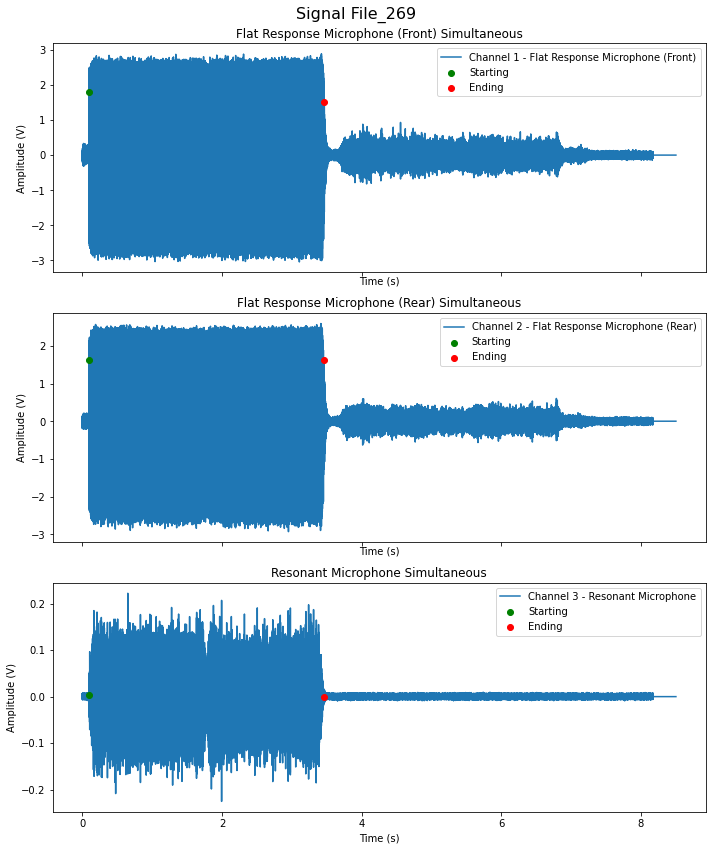

Processing files:  68%|██████████████▏      | 270/400 [1:09:50<33:59, 15.69s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_270, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_270.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672708.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_270.parquet for Channel 2


Processing files:  68%|██████████████▏      | 271/400 [1:10:05<33:35, 15.62s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670890.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_270.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670890.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_271, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_271.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672643.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_271.parquet for Channel 2


Processing files:  68%|██████████████▎      | 272/400 [1:10:21<33:16, 15.60s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670866.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_271.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670866.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_272, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_272.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672731.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_272.parquet for Channel 2


Processing files:  68%|██████████████▎      | 273/400 [1:10:36<32:54, 15.55s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671194.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_272.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671194.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_273, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_273.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673644.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_273.parquet for Channel 2


Processing files:  68%|██████████████▍      | 274/400 [1:10:52<32:32, 15.49s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671022.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_273.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671022.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_274, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_274.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672358.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_274.parquet for Channel 2


Processing files:  69%|██████████████▍      | 275/400 [1:11:07<32:11, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671155.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_274.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671155.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_275, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_275.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673390.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_275.parquet for Channel 2


Processing files:  69%|██████████████▍      | 276/400 [1:11:22<31:53, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671872.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_275.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671872.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_276, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_276.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673113.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_276.parquet for Channel 2


Processing files:  69%|██████████████▌      | 277/400 [1:11:38<31:35, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671305.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_276.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671305.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_277, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_277.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672687.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_277.parquet for Channel 2


Processing files:  70%|██████████████▌      | 278/400 [1:11:53<31:18, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671988.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_277.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671988.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_278, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_278.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672627.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_278.parquet for Channel 2


Processing files:  70%|██████████████▋      | 279/400 [1:12:08<31:02, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670667.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_278.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670667.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_279, Operation: Simultaneous, Cube 1 Mode: Conduction3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_279.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673433.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_279.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671994.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_279.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

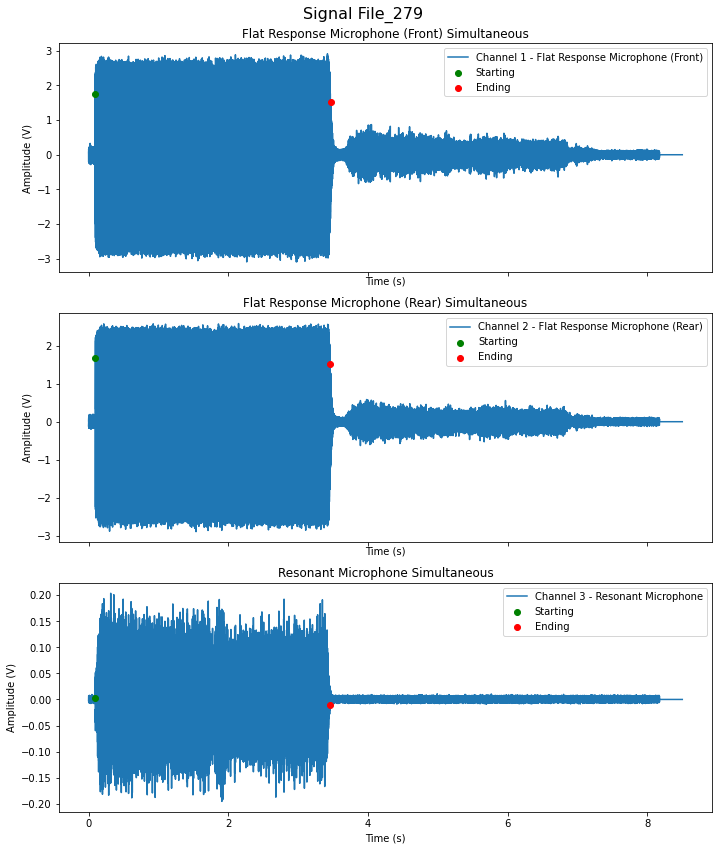

Processing files:  70%|██████████████▋      | 280/400 [1:12:25<31:21, 15.68s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_280, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_280.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526882.00, Standard Deviation: 144736.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_280.parquet for Channel 2


Processing files:  70%|██████████████▊      | 281/400 [1:12:40<31:01, 15.64s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525279.50, Standard Deviation: 144652.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_280.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525279.50, Standard Deviation: 144652.50, Num. segments: 2

Processing File: File_281, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_281.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526318.00, Standard Deviation: 145429.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_281.parquet for Channel 2


Processing files:  70%|██████████████▊      | 282/400 [1:12:56<30:43, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524924.50, Standard Deviation: 145662.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_281.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524924.50, Standard Deviation: 145662.50, Num. segments: 2

Processing File: File_282, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_282.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526523.50, Standard Deviation: 143955.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_282.parquet for Channel 2


Processing files:  71%|██████████████▊      | 283/400 [1:13:11<30:23, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525440.00, Standard Deviation: 144536.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_282.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525440.00, Standard Deviation: 144536.00, Num. segments: 2

Processing File: File_283, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_283.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526184.00, Standard Deviation: 146074.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_283.parquet for Channel 2


Processing files:  71%|██████████████▉      | 284/400 [1:13:27<30:05, 15.57s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524701.50, Standard Deviation: 145219.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_283.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524701.50, Standard Deviation: 145219.50, Num. segments: 2

Processing File: File_284, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_284.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526658.00, Standard Deviation: 143696.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_284.parquet for Channel 2


Processing files:  71%|██████████████▉      | 285/400 [1:13:42<29:43, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525274.50, Standard Deviation: 143923.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_284.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525274.50, Standard Deviation: 143923.50, Num. segments: 2

Processing File: File_285, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_285.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526650.50, Standard Deviation: 145227.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_285.parquet for Channel 2


Processing files:  72%|███████████████      | 286/400 [1:13:58<29:23, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524379.50, Standard Deviation: 145014.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_285.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524379.50, Standard Deviation: 145014.50, Num. segments: 2

Processing File: File_286, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_286.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526675.50, Standard Deviation: 143551.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_286.parquet for Channel 2


Processing files:  72%|███████████████      | 287/400 [1:14:13<29:04, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525241.00, Standard Deviation: 143767.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_286.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525241.00, Standard Deviation: 143767.00, Num. segments: 2

Processing File: File_287, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_287.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526246.50, Standard Deviation: 144606.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_287.parquet for Channel 2


Processing files:  72%|███████████████      | 288/400 [1:14:28<28:46, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524759.00, Standard Deviation: 144656.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_287.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524759.00, Standard Deviation: 144656.00, Num. segments: 2

Processing File: File_288, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_288.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 527675.50, Standard Deviation: 142917.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_288.parquet for Channel 2


Processing files:  72%|███████████████▏     | 289/400 [1:14:44<28:29, 15.41s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525448.50, Standard Deviation: 143617.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_288.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525448.50, Standard Deviation: 143617.50, Num. segments: 2

Processing File: File_289, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_289.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526755.50, Standard Deviation: 145700.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_289.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 525543.00, Standard Deviation: 145407.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_289.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Proc

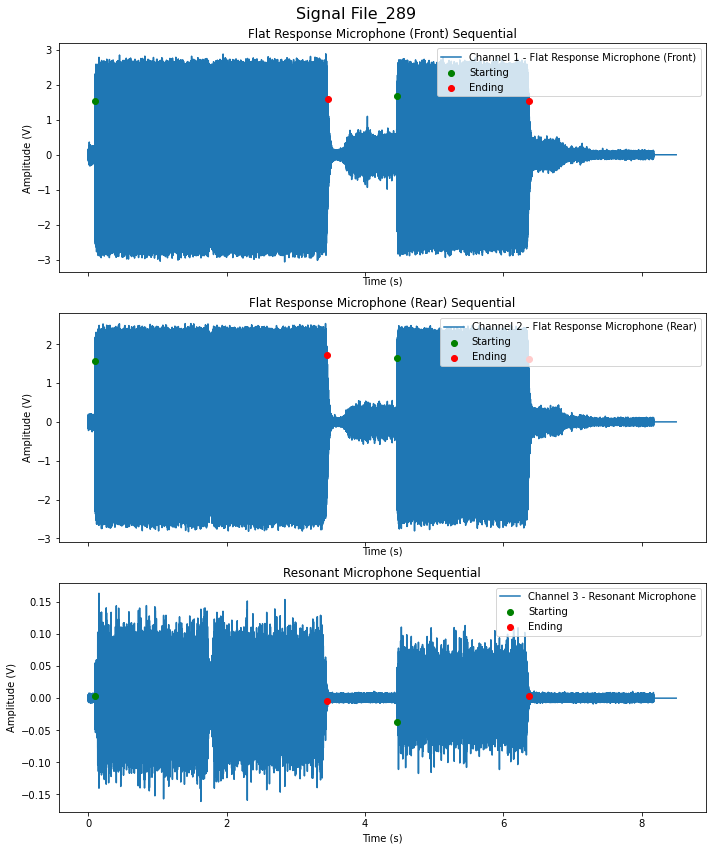

Processing files:  72%|███████████████▏     | 290/400 [1:15:00<28:50, 15.73s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_290, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_290.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526929.00, Standard Deviation: 144095.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_290.parquet for Channel 2


Processing files:  73%|███████████████▎     | 291/400 [1:15:16<28:22, 15.62s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 526051.50, Standard Deviation: 144243.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_290.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 526051.50, Standard Deviation: 144243.50, Num. segments: 2

Processing File: File_291, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_291.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525765.00, Standard Deviation: 144885.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_291.parquet for Channel 2


Processing files:  73%|███████████████▎     | 292/400 [1:15:31<27:58, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524678.00, Standard Deviation: 144691.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_291.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524678.00, Standard Deviation: 144691.00, Num. segments: 2

Processing File: File_292, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_292.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 526343.50, Standard Deviation: 143716.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_292.parquet for Channel 2


Processing files:  73%|███████████████▍     | 293/400 [1:15:47<27:43, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525898.00, Standard Deviation: 143993.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_292.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525898.00, Standard Deviation: 143993.00, Num. segments: 2

Processing File: File_293, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_293.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 525677.50, Standard Deviation: 144547.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_293.parquet for Channel 2


Processing files:  74%|███████████████▍     | 294/400 [1:16:02<27:21, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 524903.00, Standard Deviation: 144990.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_293.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 524903.00, Standard Deviation: 144990.00, Num. segments: 2

Processing File: File_294, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_294.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 527132.50, Standard Deviation: 144895.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_294.parquet for Channel 2


Processing files:  74%|███████████████▍     | 295/400 [1:16:17<27:01, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 525509.50, Standard Deviation: 144575.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_294.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 525509.50, Standard Deviation: 144575.50, Num. segments: 2

Processing File: File_295, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_295.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672777.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_295.parquet for Channel 2


Processing files:  74%|███████████████▌     | 296/400 [1:16:33<26:43, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670696.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_295.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670696.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_296, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_296.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671211.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_296.parquet for Channel 2


Processing files:  74%|███████████████▌     | 297/400 [1:16:48<26:26, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668755.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_296.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668755.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_297, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_297.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672171.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_297.parquet for Channel 2


Processing files:  74%|███████████████▋     | 298/400 [1:17:03<26:10, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669685.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_297.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669685.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_298, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_298.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671290.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_298.parquet for Channel 2


Processing files:  75%|███████████████▋     | 299/400 [1:17:19<25:54, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669043.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_298.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669043.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_299, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_299.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671717.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_299.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 669621.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_299.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

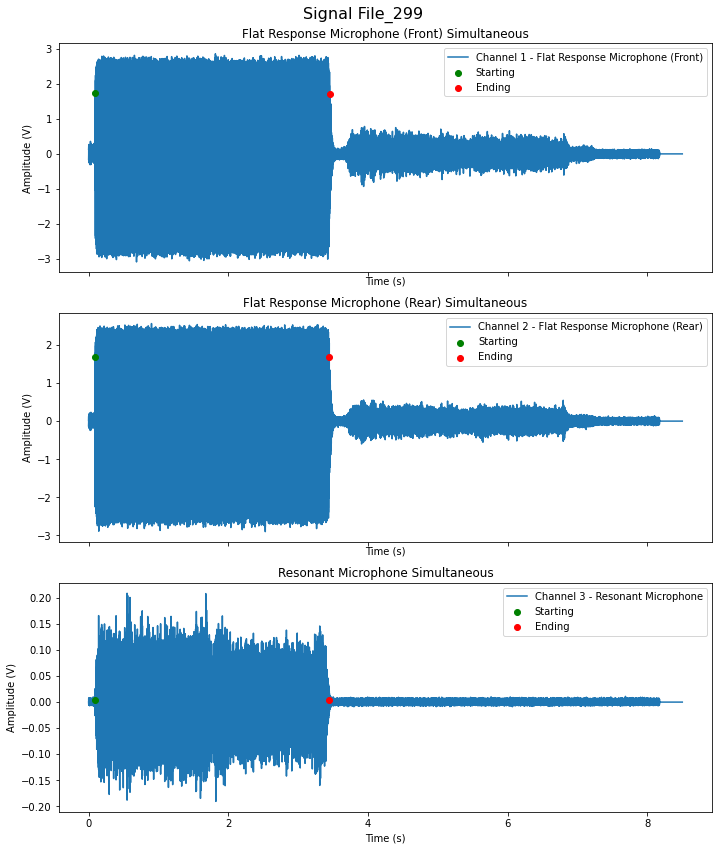

Processing files:  75%|███████████████▊     | 300/400 [1:17:35<26:07, 15.67s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_300, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_300.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671032.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_300.parquet for Channel 2


Processing files:  75%|███████████████▊     | 301/400 [1:17:50<25:42, 15.58s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668934.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_300.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668934.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_301, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_301.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672124.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_301.parquet for Channel 2


Processing files:  76%|███████████████▊     | 302/400 [1:18:06<25:20, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670357.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_301.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670357.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_302, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_302.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670029.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_302.parquet for Channel 2


Processing files:  76%|███████████████▉     | 303/400 [1:18:21<25:00, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668841.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_302.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668841.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_303, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_303.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671896.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_303.parquet for Channel 2


Processing files:  76%|███████████████▉     | 304/400 [1:18:37<24:42, 15.44s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670510.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_303.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670510.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_304, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_304.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670678.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_304.parquet for Channel 2


Processing files:  76%|████████████████     | 305/400 [1:18:52<24:24, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669017.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_304.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669017.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_305, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_305.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671425.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_305.parquet for Channel 2


Processing files:  76%|████████████████     | 306/400 [1:19:07<24:12, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671515.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_305.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671515.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_306, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_306.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670977.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_306.parquet for Channel 2


Processing files:  77%|████████████████     | 307/400 [1:19:23<23:58, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 668662.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_306.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 668662.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_307, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_307.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671259.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_307.parquet for Channel 2


Processing files:  77%|████████████████▏    | 308/400 [1:19:39<23:45, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670284.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_307.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670284.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_308, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_308.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 670775.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_308.parquet for Channel 2


Processing files:  77%|████████████████▏    | 309/400 [1:19:54<23:31, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 669906.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_308.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 669906.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_309, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Conduction3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_309.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 671713.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_309.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670429.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_309.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segme

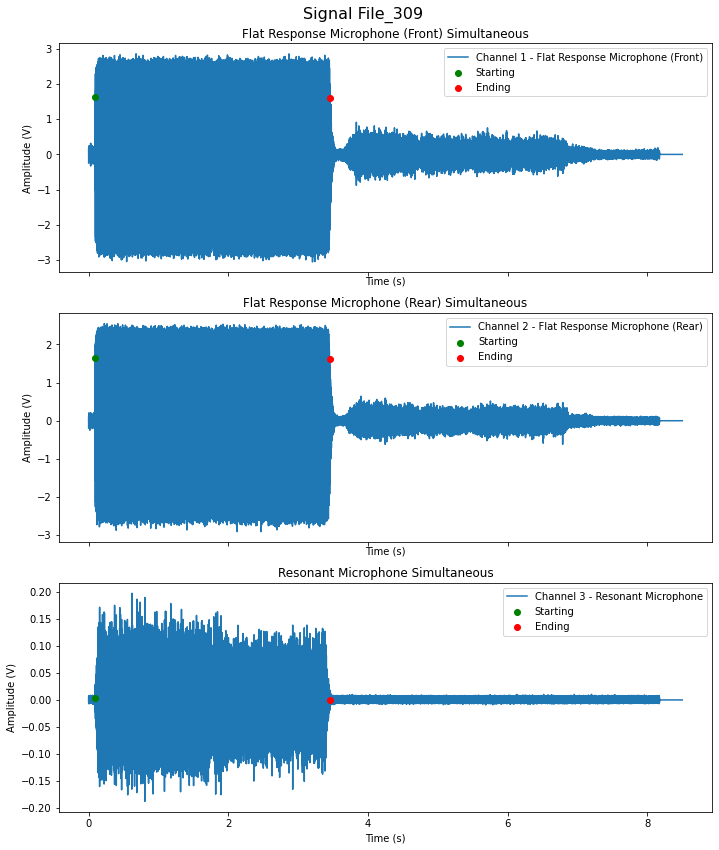

Processing files:  78%|████████████████▎    | 310/400 [1:20:10<23:39, 15.77s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_310, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_310.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671258.50, Standard Deviation: 271.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_310.parquet for Channel 2


Processing files:  78%|████████████████▎    | 311/400 [1:20:26<23:12, 15.64s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669949.00, Standard Deviation: 912.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_310.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669949.00, Standard Deviation: 912.00, Num. segments: 2

Processing File: File_311, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_311.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671154.50, Standard Deviation: 310.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_311.parquet for Channel 2


Processing files:  78%|████████████████▍    | 312/400 [1:20:41<22:48, 15.56s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669811.50, Standard Deviation: 427.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_311.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669811.50, Standard Deviation: 427.50, Num. segments: 2

Processing File: File_312, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_312.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670225.00, Standard Deviation: 7.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_312.parquet for Channel 2


Processing files:  78%|████████████████▍    | 313/400 [1:20:57<22:28, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669679.00, Standard Deviation: 242.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_312.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669679.00, Standard Deviation: 242.00, Num. segments: 2

Processing File: File_313, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_313.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670227.50, Standard Deviation: 924.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_313.parquet for Channel 2


Processing files:  78%|████████████████▍    | 314/400 [1:21:12<22:09, 15.46s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670143.50, Standard Deviation: 1101.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_313.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670143.50, Standard Deviation: 1101.50, Num. segments: 2

Processing File: File_314, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_314.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670578.50, Standard Deviation: 391.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_314.parquet for Channel 2


Processing files:  79%|████████████████▌    | 315/400 [1:21:27<21:55, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669793.50, Standard Deviation: 878.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_314.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669793.50, Standard Deviation: 878.50, Num. segments: 2

Processing File: File_315, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_315.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670309.00, Standard Deviation: 491.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_315.parquet for Channel 2


Processing files:  79%|████████████████▌    | 316/400 [1:21:43<21:41, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668707.50, Standard Deviation: 25.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_315.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668707.50, Standard Deviation: 25.50, Num. segments: 2

Processing File: File_316, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_316.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670508.00, Standard Deviation: 12.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_316.parquet for Channel 2


Processing files:  79%|████████████████▋    | 317/400 [1:21:59<21:28, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669054.50, Standard Deviation: 133.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_316.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669054.50, Standard Deviation: 133.50, Num. segments: 2

Processing File: File_317, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_317.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670943.00, Standard Deviation: 1206.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_317.parquet for Channel 2


Processing files:  80%|████████████████▋    | 318/400 [1:22:14<21:14, 15.54s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668586.50, Standard Deviation: 352.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_317.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668586.50, Standard Deviation: 352.50, Num. segments: 2

Processing File: File_318, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_318.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670260.50, Standard Deviation: 211.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_318.parquet for Channel 2


Processing files:  80%|████████████████▋    | 319/400 [1:22:30<20:59, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668352.50, Standard Deviation: 54.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_318.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668352.50, Standard Deviation: 54.50, Num. segments: 2

Processing File: File_319, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_319.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671175.50, Standard Deviation: 2075.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_319.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 669849.00, Standard Deviation: 1399.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_319.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 se

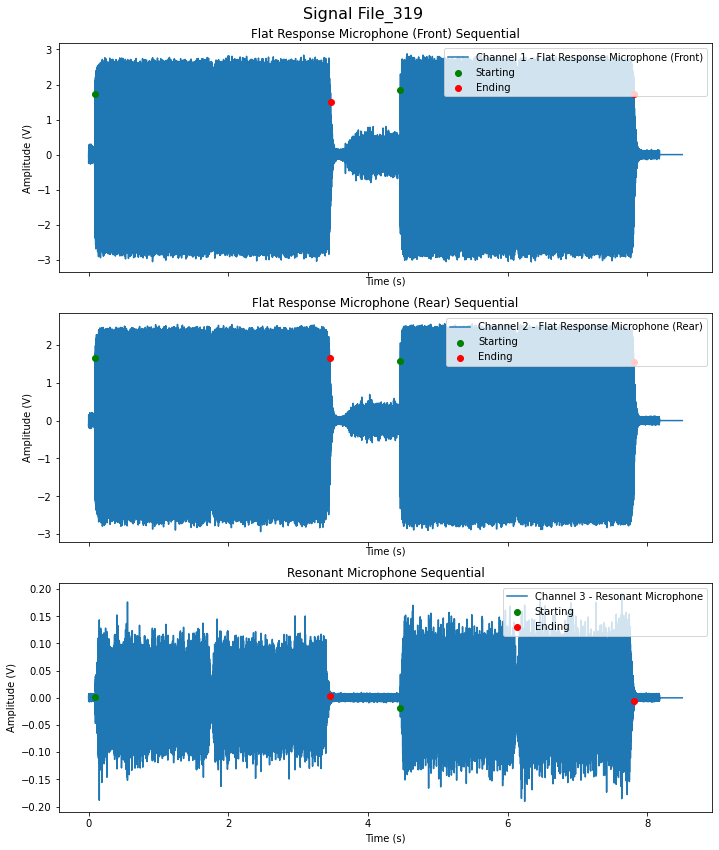

Processing files:  80%|████████████████▊    | 320/400 [1:22:47<21:14, 15.93s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_320, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_320.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670240.00, Standard Deviation: 508.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_320.parquet for Channel 2


Processing files:  80%|████████████████▊    | 321/400 [1:23:02<20:50, 15.83s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669522.50, Standard Deviation: 192.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_320.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669522.50, Standard Deviation: 192.50, Num. segments: 2

Processing File: File_321, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_321.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670942.00, Standard Deviation: 1651.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_321.parquet for Channel 2


Processing files:  80%|████████████████▉    | 322/400 [1:23:18<20:28, 15.75s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669336.00, Standard Deviation: 1418.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_321.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669336.00, Standard Deviation: 1418.00, Num. segments: 2

Processing File: File_322, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_322.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670266.00, Standard Deviation: 533.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_322.parquet for Channel 2


Processing files:  81%|████████████████▉    | 323/400 [1:23:33<20:09, 15.70s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669246.50, Standard Deviation: 94.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_322.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669246.50, Standard Deviation: 94.50, Num. segments: 2

Processing File: File_323, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_323.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 669825.50, Standard Deviation: 849.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_323.parquet for Channel 2


Processing files:  81%|█████████████████    | 324/400 [1:23:49<19:50, 15.66s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669542.50, Standard Deviation: 1118.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_323.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669542.50, Standard Deviation: 1118.50, Num. segments: 2

Processing File: File_324, Operation: Sequential, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_324.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670118.00, Standard Deviation: 730.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_324.parquet for Channel 2


Processing files:  81%|█████████████████    | 325/400 [1:24:04<19:29, 15.60s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669115.00, Standard Deviation: 653.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_324.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669115.00, Standard Deviation: 653.00, Num. segments: 2

Processing File: File_325, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_325.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672183.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_325.parquet for Channel 2


Processing files:  82%|█████████████████    | 326/400 [1:24:20<19:11, 15.57s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670590.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_325.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670590.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_326, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_326.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672558.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_326.parquet for Channel 2


Processing files:  82%|█████████████████▏   | 327/400 [1:24:35<18:54, 15.54s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671253.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_326.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671253.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_327, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_327.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673334.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_327.parquet for Channel 2


Processing files:  82%|█████████████████▏   | 328/400 [1:24:51<18:39, 15.54s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671705.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_327.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671705.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_328, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_328.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673759.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_328.parquet for Channel 2


Processing files:  82%|█████████████████▎   | 329/400 [1:25:06<18:21, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671472.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_328.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671472.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_329, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_329.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672969.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_329.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 672699.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_329.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments

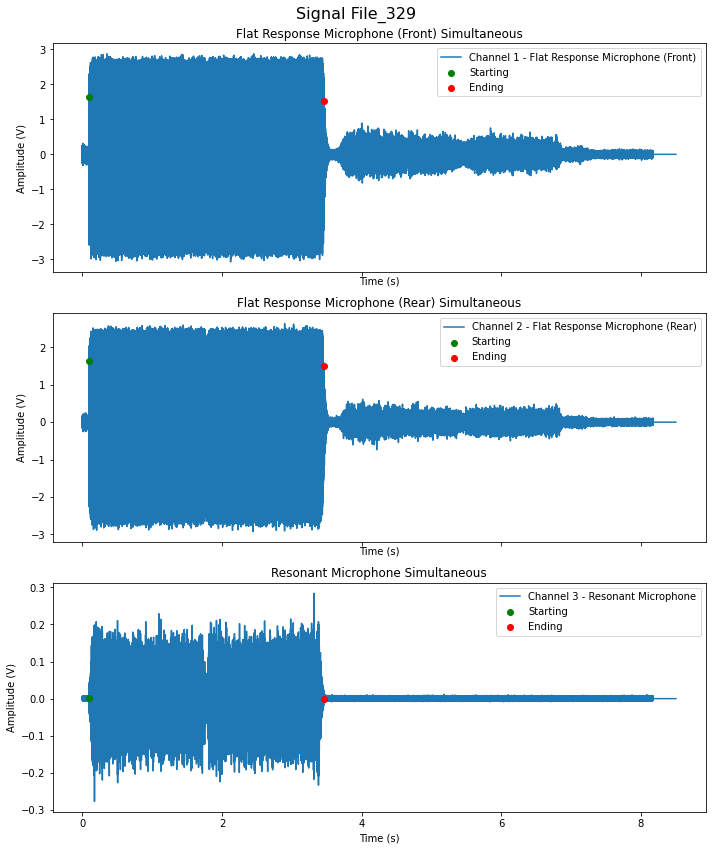

Processing files:  82%|█████████████████▎   | 330/400 [1:25:23<18:23, 15.76s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_330, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_330.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673016.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_330.parquet for Channel 2


Processing files:  83%|█████████████████▍   | 331/400 [1:25:38<18:02, 15.69s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672239.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_330.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672239.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_331, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_331.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674152.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_331.parquet for Channel 2


Processing files:  83%|█████████████████▍   | 332/400 [1:25:54<17:43, 15.64s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672325.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_331.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672325.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_332, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_332.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673170.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_332.parquet for Channel 2


Processing files:  83%|█████████████████▍   | 333/400 [1:26:09<17:24, 15.59s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672902.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_332.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672902.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_333, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_333.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672849.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_333.parquet for Channel 2


Processing files:  84%|█████████████████▌   | 334/400 [1:26:25<17:06, 15.56s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671682.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_333.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671682.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_334, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_334.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673495.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_334.parquet for Channel 2


Processing files:  84%|█████████████████▌   | 335/400 [1:26:40<16:49, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672104.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_334.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672104.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_335, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_335.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674059.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_335.parquet for Channel 2


Processing files:  84%|█████████████████▋   | 336/400 [1:26:56<16:32, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672521.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_335.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672521.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_336, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_336.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673276.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_336.parquet for Channel 2


Processing files:  84%|█████████████████▋   | 337/400 [1:27:11<16:14, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671402.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_336.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671402.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_337, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_337.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673569.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_337.parquet for Channel 2


Processing files:  84%|█████████████████▋   | 338/400 [1:27:26<16:01, 15.50s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671839.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_337.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671839.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_338, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_338.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673840.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_338.parquet for Channel 2


Processing files:  85%|█████████████████▊   | 339/400 [1:27:42<15:43, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_338.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_339, Operation: Simultaneous, Cube 1 Mode: Keyhole1, Cube 2 Mode: Keyhole1
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_339.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673122.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_339.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671402.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_339.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments

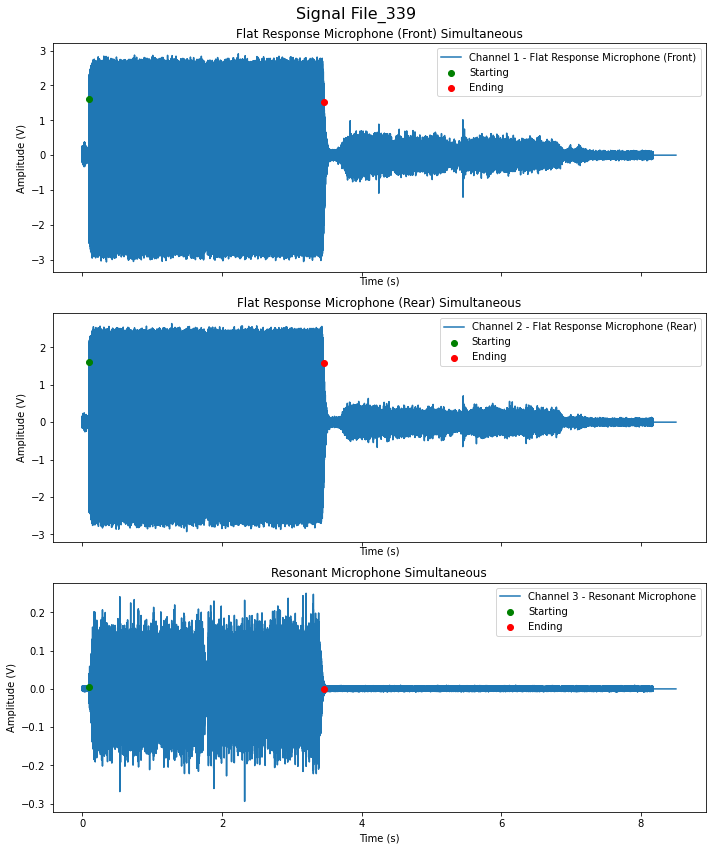

Processing files:  85%|█████████████████▊   | 340/400 [1:27:58<15:43, 15.72s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_340, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_340.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670573.00, Standard Deviation: 299.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_340.parquet for Channel 2


Processing files:  85%|█████████████████▉   | 341/400 [1:28:14<15:23, 15.65s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669452.00, Standard Deviation: 166.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_340.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669452.00, Standard Deviation: 166.00, Num. segments: 2

Processing File: File_341, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_341.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670453.50, Standard Deviation: 1355.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_341.parquet for Channel 2


Processing files:  86%|█████████████████▉   | 342/400 [1:28:29<15:05, 15.61s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670187.00, Standard Deviation: 1085.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_341.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670187.00, Standard Deviation: 1085.00, Num. segments: 2

Processing File: File_342, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_342.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670803.50, Standard Deviation: 210.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_342.parquet for Channel 2


Processing files:  86%|██████████████████   | 343/400 [1:28:45<14:48, 15.59s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668994.50, Standard Deviation: 59.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_342.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668994.50, Standard Deviation: 59.50, Num. segments: 2

Processing File: File_343, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_343.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671249.00, Standard Deviation: 780.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_343.parquet for Channel 2


Processing files:  86%|██████████████████   | 344/400 [1:29:00<14:31, 15.57s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669736.00, Standard Deviation: 955.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_343.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669736.00, Standard Deviation: 955.00, Num. segments: 2

Processing File: File_344, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_344.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670542.50, Standard Deviation: 242.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_344.parquet for Channel 2


Processing files:  86%|██████████████████   | 345/400 [1:29:16<14:14, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669083.50, Standard Deviation: 153.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_344.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669083.50, Standard Deviation: 153.50, Num. segments: 2

Processing File: File_345, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_345.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671692.50, Standard Deviation: 860.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_345.parquet for Channel 2


Processing files:  86%|██████████████████▏  | 346/400 [1:29:31<13:56, 15.49s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670274.00, Standard Deviation: 1142.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_345.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670274.00, Standard Deviation: 1142.00, Num. segments: 2

Processing File: File_346, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_346.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670164.50, Standard Deviation: 343.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_346.parquet for Channel 2


Processing files:  87%|██████████████████▏  | 347/400 [1:29:46<13:39, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669148.00, Standard Deviation: 63.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_346.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669148.00, Standard Deviation: 63.00, Num. segments: 2

Processing File: File_347, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_347.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671392.00, Standard Deviation: 1618.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_347.parquet for Channel 2


Processing files:  87%|██████████████████▎  | 348/400 [1:30:02<13:23, 15.45s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669785.50, Standard Deviation: 1220.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_347.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669785.50, Standard Deviation: 1220.50, Num. segments: 2

Processing File: File_348, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_348.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670627.50, Standard Deviation: 186.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_348.parquet for Channel 2


Processing files:  87%|██████████████████▎  | 349/400 [1:30:17<13:06, 15.42s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669874.50, Standard Deviation: 112.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_348.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669874.50, Standard Deviation: 112.50, Num. segments: 2

Processing File: File_349, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_349.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670744.00, Standard Deviation: 507.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_349.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 669544.50, Standard Deviation: 1005.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_349.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 s

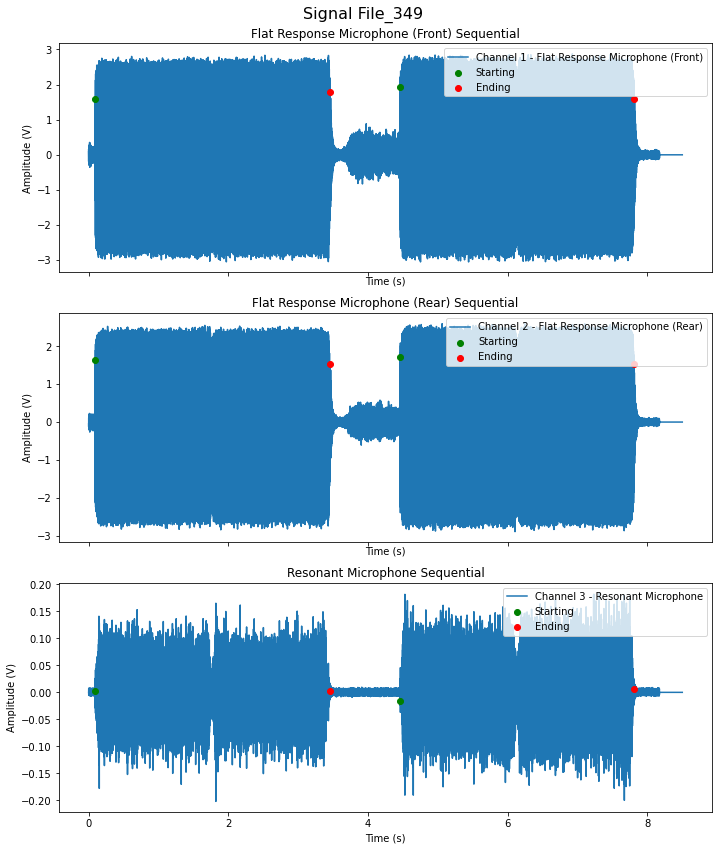

Processing files:  88%|██████████████████▍  | 350/400 [1:30:34<13:08, 15.77s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_350, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_350.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670162.50, Standard Deviation: 233.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_350.parquet for Channel 2


Processing files:  88%|██████████████████▍  | 351/400 [1:30:49<12:46, 15.65s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668728.50, Standard Deviation: 199.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_350.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668728.50, Standard Deviation: 199.50, Num. segments: 2

Processing File: File_351, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_351.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670873.00, Standard Deviation: 642.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_351.parquet for Channel 2


Processing files:  88%|██████████████████▍  | 352/400 [1:31:05<12:26, 15.56s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670114.00, Standard Deviation: 1085.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_351.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670114.00, Standard Deviation: 1085.00, Num. segments: 2

Processing File: File_352, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_352.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670707.00, Standard Deviation: 18.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_352.parquet for Channel 2


Processing files:  88%|██████████████████▌  | 353/400 [1:31:20<12:10, 15.55s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670259.00, Standard Deviation: 451.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_352.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670259.00, Standard Deviation: 451.00, Num. segments: 2

Processing File: File_353, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_353.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671216.00, Standard Deviation: 1154.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_353.parquet for Channel 2


Processing files:  88%|██████████████████▌  | 354/400 [1:31:36<11:54, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669624.50, Standard Deviation: 371.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_353.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669624.50, Standard Deviation: 371.50, Num. segments: 2

Processing File: File_354, Operation: Sequential, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_354.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670462.50, Standard Deviation: 435.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_354.parquet for Channel 2


Processing files:  89%|██████████████████▋  | 355/400 [1:31:51<11:38, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669494.50, Standard Deviation: 978.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_354.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669494.50, Standard Deviation: 978.50, Num. segments: 2

Processing File: File_355, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_355.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673091.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_355.parquet for Channel 2


Processing files:  89%|██████████████████▋  | 356/400 [1:32:07<11:22, 15.52s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671424.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_355.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671424.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_356, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_356.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673903.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_356.parquet for Channel 2


Processing files:  89%|██████████████████▋  | 357/400 [1:32:22<11:07, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671458.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_356.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671458.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_357, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_357.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674124.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_357.parquet for Channel 2


Processing files:  90%|██████████████████▊  | 358/400 [1:32:38<10:52, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672794.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_357.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672794.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_358, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_358.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673541.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_358.parquet for Channel 2


Processing files:  90%|██████████████████▊  | 359/400 [1:32:53<10:36, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671272.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_358.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671272.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_359, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_359.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672402.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_359.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 672557.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_359.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments

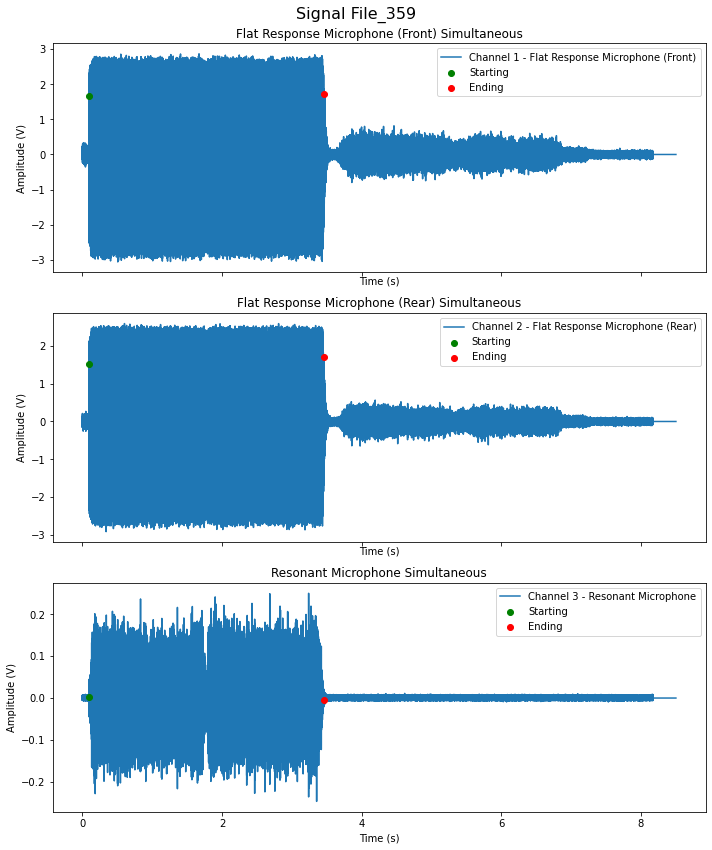

Processing files:  90%|██████████████████▉  | 360/400 [1:33:10<10:33, 15.83s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_360, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_360.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673594.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_360.parquet for Channel 2


Processing files:  90%|██████████████████▉  | 361/400 [1:33:25<10:11, 15.69s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671853.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_360.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671853.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_361, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_361.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674231.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_361.parquet for Channel 2


Processing files:  90%|███████████████████  | 362/400 [1:33:40<09:52, 15.60s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672481.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_361.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672481.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_362, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_362.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673087.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_362.parquet for Channel 2


Processing files:  91%|███████████████████  | 363/400 [1:33:56<09:34, 15.53s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672142.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_362.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672142.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_363, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_363.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673810.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_363.parquet for Channel 2


Processing files:  91%|███████████████████  | 364/400 [1:34:11<09:17, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671435.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_363.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671435.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_364, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_364.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673164.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_364.parquet for Channel 2


Processing files:  91%|███████████████████▏ | 365/400 [1:34:27<09:00, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672042.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_364.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672042.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_365, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_365.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674261.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_365.parquet for Channel 2


Processing files:  92%|███████████████████▏ | 366/400 [1:34:42<08:44, 15.43s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672118.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_365.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672118.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_366, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_366.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673456.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_366.parquet for Channel 2


Processing files:  92%|███████████████████▎ | 367/400 [1:34:57<08:28, 15.41s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671818.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_366.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671818.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_367, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_367.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672928.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_367.parquet for Channel 2


Processing files:  92%|███████████████████▎ | 368/400 [1:35:13<08:12, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672125.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_367.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672125.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_368, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_368.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673550.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_368.parquet for Channel 2


Processing files:  92%|███████████████████▎ | 369/400 [1:35:28<07:57, 15.39s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_368.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671668.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_369, Operation: Simultaneous, Cube 1 Mode: Keyhole2, Cube 2 Mode: Keyhole2
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_369.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673913.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_369.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671656.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_369.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments

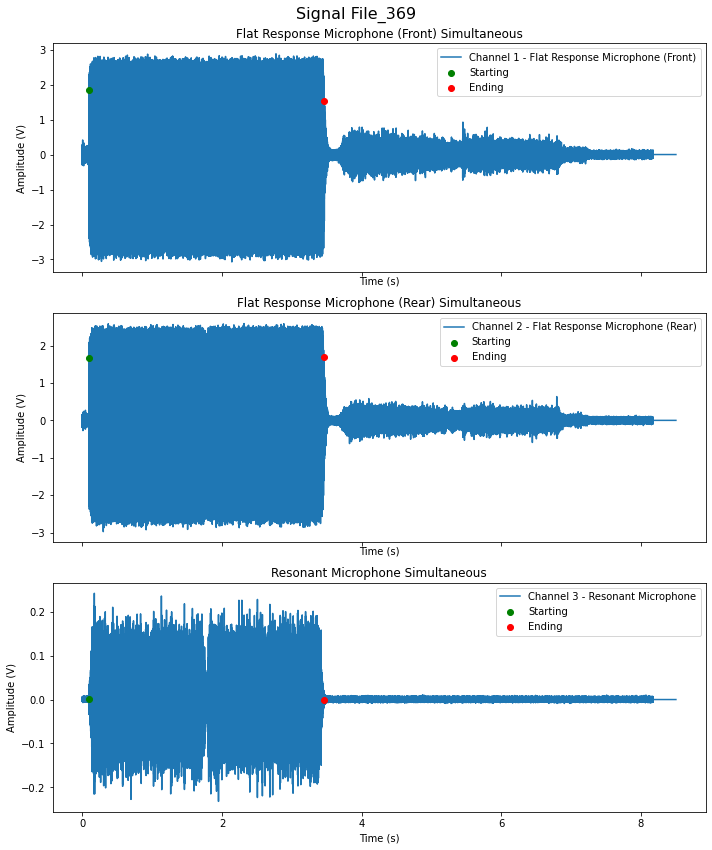

Processing files:  92%|███████████████████▍ | 370/400 [1:35:44<07:50, 15.68s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_370, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_370.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670165.50, Standard Deviation: 74.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_370.parquet for Channel 2


Processing files:  93%|███████████████████▍ | 371/400 [1:36:00<07:31, 15.58s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668540.00, Standard Deviation: 203.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_370.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668540.00, Standard Deviation: 203.00, Num. segments: 2

Processing File: File_371, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_371.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671446.50, Standard Deviation: 1343.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_371.parquet for Channel 2


Processing files:  93%|███████████████████▌ | 372/400 [1:36:15<07:14, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669606.00, Standard Deviation: 548.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_371.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669606.00, Standard Deviation: 548.00, Num. segments: 2

Processing File: File_372, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_372.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670882.00, Standard Deviation: 109.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_372.parquet for Channel 2


Processing files:  93%|███████████████████▌ | 373/400 [1:36:31<06:58, 15.50s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669261.50, Standard Deviation: 142.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_372.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669261.50, Standard Deviation: 142.50, Num. segments: 2

Processing File: File_373, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_373.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671362.00, Standard Deviation: 1763.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_373.parquet for Channel 2


Processing files:  94%|███████████████████▋ | 374/400 [1:36:46<06:43, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669766.50, Standard Deviation: 672.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_373.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669766.50, Standard Deviation: 672.50, Num. segments: 2

Processing File: File_374, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_374.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 669975.00, Standard Deviation: 109.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_374.parquet for Channel 2


Processing files:  94%|███████████████████▋ | 375/400 [1:37:02<06:27, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668934.50, Standard Deviation: 15.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_374.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668934.50, Standard Deviation: 15.50, Num. segments: 2

Processing File: File_375, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_375.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670664.50, Standard Deviation: 1077.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_375.parquet for Channel 2


Processing files:  94%|███████████████████▋ | 376/400 [1:37:17<06:12, 15.52s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669336.50, Standard Deviation: 1084.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_375.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669336.50, Standard Deviation: 1084.50, Num. segments: 2

Processing File: File_376, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_376.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670943.50, Standard Deviation: 74.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_376.parquet for Channel 2


Processing files:  94%|███████████████████▊ | 377/400 [1:37:33<05:56, 15.51s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669426.50, Standard Deviation: 179.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_376.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669426.50, Standard Deviation: 179.50, Num. segments: 2

Processing File: File_377, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_377.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670715.50, Standard Deviation: 1449.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_377.parquet for Channel 2


Processing files:  94%|███████████████████▊ | 378/400 [1:37:48<05:40, 15.47s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669847.50, Standard Deviation: 737.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_377.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669847.50, Standard Deviation: 737.50, Num. segments: 2

Processing File: File_378, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_378.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670381.50, Standard Deviation: 72.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_378.parquet for Channel 2


Processing files:  95%|███████████████████▉ | 379/400 [1:38:03<05:24, 15.44s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669100.50, Standard Deviation: 237.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_378.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669100.50, Standard Deviation: 237.50, Num. segments: 2

Processing File: File_379, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_379.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 672168.50, Standard Deviation: 1422.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_379.parquet for Channel 2
Channel 2: Processed with 2 segments detected.
Average Segment Length: 669377.00, Standard Deviation: 125.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_379.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 s

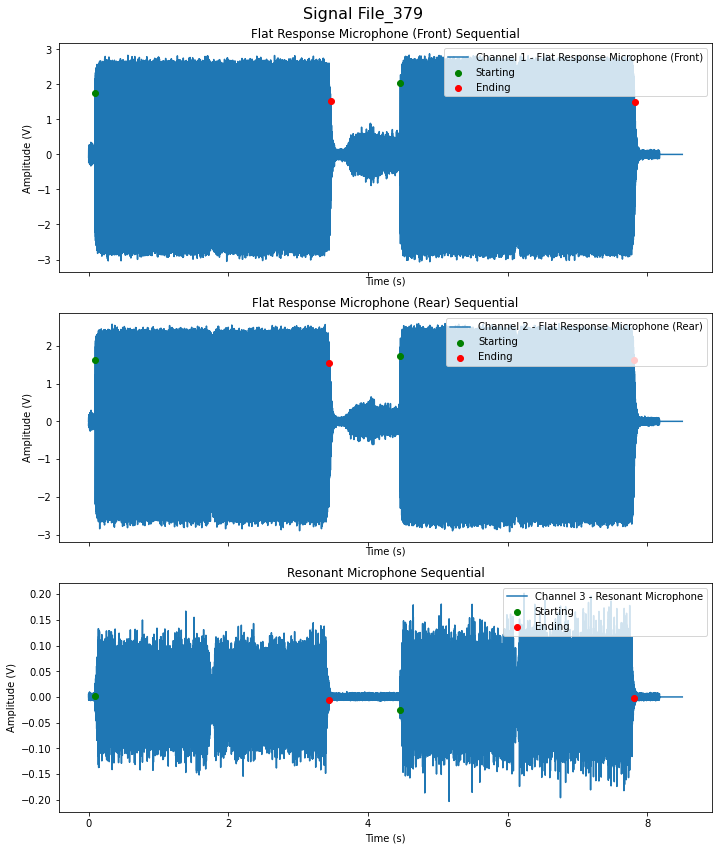

Processing files:  95%|███████████████████▉ | 380/400 [1:38:20<05:15, 15.80s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_380, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_380.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670096.50, Standard Deviation: 8.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_380.parquet for Channel 2


Processing files:  95%|████████████████████ | 381/400 [1:38:35<04:58, 15.70s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 668987.00, Standard Deviation: 158.00, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_380.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 668987.00, Standard Deviation: 158.00, Num. segments: 2

Processing File: File_381, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_381.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671021.00, Standard Deviation: 771.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_381.parquet for Channel 2


Processing files:  96%|████████████████████ | 382/400 [1:38:51<04:41, 15.65s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669461.50, Standard Deviation: 400.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_381.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669461.50, Standard Deviation: 400.50, Num. segments: 2

Processing File: File_382, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_382.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 669877.00, Standard Deviation: 26.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_382.parquet for Channel 2


Processing files:  96%|████████████████████ | 383/400 [1:39:06<04:25, 15.60s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669298.50, Standard Deviation: 69.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_382.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669298.50, Standard Deviation: 69.50, Num. segments: 2

Processing File: File_383, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_383.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 671659.50, Standard Deviation: 1016.50, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_383.parquet for Channel 2


Processing files:  96%|████████████████████▏| 384/400 [1:39:22<04:08, 15.53s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 670701.50, Standard Deviation: 1503.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_383.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 670701.50, Standard Deviation: 1503.50, Num. segments: 2

Processing File: File_384, Operation: Sequential, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_384.parquet for Channel 1
Channel 1: Processed with 2 segments detected.
Average Segment Length: 670519.00, Standard Deviation: 141.00, Num. segments: 2
Reading data from ./Raw_data/channel_2/File_384.parquet for Channel 2


Processing files:  96%|████████████████████▏| 385/400 [1:39:37<03:52, 15.48s/it]

Channel 2: Processed with 2 segments detected.
Average Segment Length: 669218.50, Standard Deviation: 3.50, Num. segments: 2
Reading data from ./Raw_data/channel_3/File_384.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 2 segments detected.
Average Segment Length: 669218.50, Standard Deviation: 3.50, Num. segments: 2

Processing File: File_385, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_385.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672599.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_385.parquet for Channel 2


Processing files:  96%|████████████████████▎| 386/400 [1:39:53<03:36, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670896.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_385.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670896.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_386, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_386.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 674697.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_386.parquet for Channel 2


Processing files:  97%|████████████████████▎| 387/400 [1:40:08<03:20, 15.45s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672454.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_386.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672454.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_387, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_387.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673399.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_387.parquet for Channel 2


Processing files:  97%|████████████████████▎| 388/400 [1:40:24<03:05, 15.47s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672472.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_387.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672472.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_388, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_388.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672929.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_388.parquet for Channel 2


Processing files:  97%|████████████████████▍| 389/400 [1:40:39<02:50, 15.48s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672085.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_388.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672085.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_389, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_389.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673516.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_389.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 671129.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_389.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments

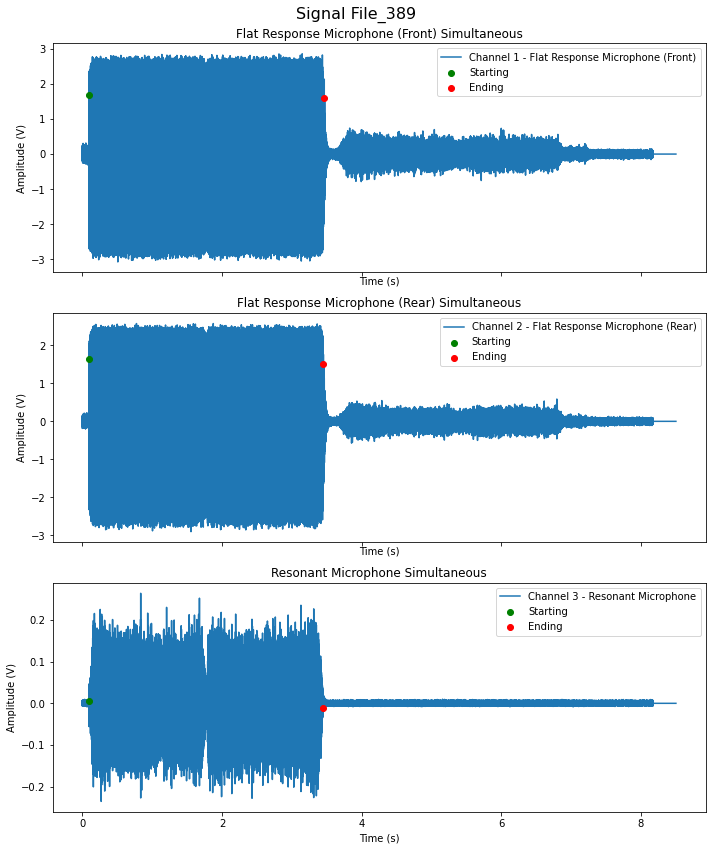

Processing files:  98%|████████████████████▍| 390/400 [1:40:55<02:37, 15.76s/it]

--------------------------------------------------------------------------------------------------------------------------------

Processing File: File_390, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_390.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673491.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_390.parquet for Channel 2


Processing files:  98%|████████████████████▌| 391/400 [1:41:11<02:21, 15.68s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671657.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_390.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671657.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_391, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_391.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672375.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_391.parquet for Channel 2


Processing files:  98%|████████████████████▌| 392/400 [1:41:26<02:04, 15.58s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670516.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_391.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670516.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_392, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_392.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673309.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_392.parquet for Channel 2


Processing files:  98%|████████████████████▋| 393/400 [1:41:42<01:48, 15.51s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 671676.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_392.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 671676.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_393, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_393.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673474.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_393.parquet for Channel 2


Processing files:  98%|████████████████████▋| 394/400 [1:41:57<01:32, 15.46s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672538.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_393.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672538.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_394, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_394.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673204.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_394.parquet for Channel 2


Processing files:  99%|████████████████████▋| 395/400 [1:42:12<01:17, 15.42s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672323.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_394.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672323.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_395, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_395.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673714.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_395.parquet for Channel 2


Processing files:  99%|████████████████████▊| 396/400 [1:42:28<01:01, 15.40s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672407.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_395.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672407.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_396, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_396.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673168.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_396.parquet for Channel 2


Processing files:  99%|████████████████████▊| 397/400 [1:42:43<00:46, 15.38s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672499.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_396.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672499.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_397, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_397.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 673909.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_397.parquet for Channel 2


Processing files: 100%|████████████████████▉| 398/400 [1:42:58<00:30, 15.37s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 670664.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_397.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 670664.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_398, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_398.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672620.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_398.parquet for Channel 2


Processing files: 100%|████████████████████▉| 399/400 [1:43:14<00:15, 15.36s/it]

Channel 2: Processed with 1 segments detected.
Average Segment Length: 672313.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_398.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments detected.
Average Segment Length: 672313.00, Standard Deviation: 0.00, Num. segments: 1

Processing File: File_399, Operation: Simultaneous, Cube 1 Mode: Keyhole3, Cube 2 Mode: Keyhole3
Skipping Channel 0 as per requirements.
Reading data from ./Raw_data/channel_1/File_399.parquet for Channel 1
Channel 1: Processed with 1 segments detected.
Average Segment Length: 672662.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_2/File_399.parquet for Channel 2
Channel 2: Processed with 1 segments detected.
Average Segment Length: 670419.00, Standard Deviation: 0.00, Num. segments: 1
Reading data from ./Raw_data/channel_3/File_399.parquet for Channel 3
Using vecchia ciabatta
Channel 3: Processed with 1 segments

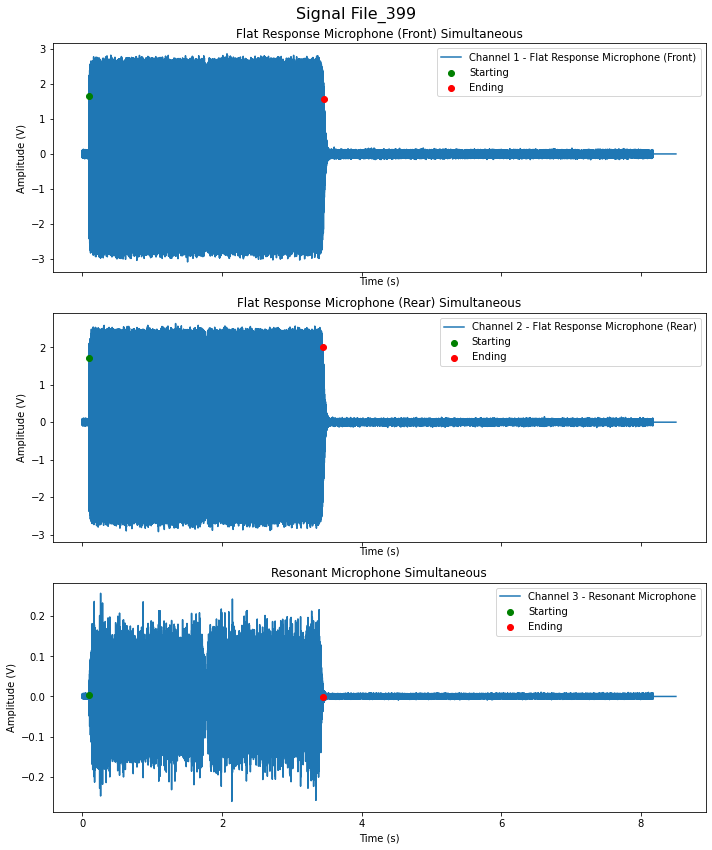

Processing files: 100%|█████████████████████| 400/400 [1:43:30<00:00, 15.53s/it]

--------------------------------------------------------------------------------------------------------------------------------


In [8]:
data_path = './Raw_data/'

all_processed_data = parse_multimodal_signals_corrected_with_plotting(data_path, threshold=1.5)

In [9]:
import pickle

# Save the dictionary with pickle
with open('my_dic.pkl', 'wb') as file:
    pickle.dump(all_processed_data, file)

In [12]:
def analyze_all_processed_data(all_processed_data):
    for file_name, data in all_processed_data.items():
        print(f"File {file_name}:")
        
        # Processed Data Analysis
        for channel_key, channel_info in data.items():
            num_segments = len(channel_info['segments'])
            mode = channel_info['Operation']
            print(f"  {channel_key}: {num_segments} segments detected, mode: {mode}")

        print('----'*20)

In [13]:
analyze_all_processed_data(all_processed_data)

File File_0:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_1:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_2:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_3:
  Channel_1: 2 segments detected, mode: Sequential
  Channel_2: 2 segments detected, mode: Sequential
  Channel_3: 2 segments detected, mode: Sequential
--------------------------------------------------------------------------------
File File_4: